<a href="https://colab.research.google.com/github/CorentinMAG/TEXT_MINING_HP/blob/main/TEXT_MINING_HP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Harry Potter books analysis

In [1]:
# all imports

import random
import time
import pandas as pd
import numpy as np
import os
import math
import string
import re
from string import ascii_letters,punctuation,digits,whitespace
from collections import OrderedDict,Counter
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import collections
from scipy.stats import chi2_contingency 
import matplotlib.pyplot as plt
import textwrap
import pprint
import warnings
from nltk.stem import WordNetLemmatizer 
!pip install gensim==3.8.3
import gensim
from gensim.models import LdaModel,CoherenceModel
from pprint import pprint
!pip install pyLDAvis
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim  # don't skip this
import operator
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({'font.size':13})
%matplotlib notebook
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 1.6MB 4.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=027ad224278579aafa9dbe7c05ce4345b15b6909b3cd0003f5d60f35a20fb28c
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


## Import dataset

In [2]:
# books path

dataset = os.path.join(os.getcwd(),'drive/MyDrive/datasets/harry_potter/books_clean')

book1 = os.path.join(dataset,'HPBook1.txt')
book2 = os.path.join(dataset,'HPBook2.txt')
book3 = os.path.join(dataset,'HPBook3.txt')
book4 = os.path.join(dataset,'HPBook4.txt')
book5 = os.path.join(dataset,'HPBook5.txt')
book6 = os.path.join(dataset,'HPBook6.txt')
book7 = os.path.join(dataset,'HPBook7.txt')

In [3]:
# load books into dataframes

hp_1 = pd.read_table(book1,sep='@',index_col=['Book','Chapter'])
hp_2 = pd.read_table(book2,sep='@',index_col=['Book','Chapter'])
hp_3 = pd.read_table(book3,sep='@',index_col=['Book','Chapter'])
hp_4 = pd.read_table(book4,sep='@',index_col=['Book','Chapter'])
hp_5 = pd.read_table(book5,sep='@',index_col=['Book','Chapter'])
hp_6 = pd.read_table(book6,sep='@',index_col=['Book','Chapter'])
hp_7 = pd.read_table(book7,sep='@',index_col=['Book','Chapter'])

all_books = pd.concat([hp_1,hp_2,hp_3,hp_4,hp_5,hp_6,hp_7])

In [4]:
all_books

Text
Book Chapter                                                   
1    1        THE BOY WHO LIVED  Mr. and Mrs. Dursley, of nu...
     2        THE VANISHING GLASS  Nearly ten years had pass...
     3        THE LETTERS FROM NO ONE  The escape of the Bra...
     4        THE KEEPER OF THE KEYS  BOOM. They knocked aga...
     5        DIAGON ALLEY  Harry woke early the next mornin...
...                                                         ...
7    33       Harry remained kneeling at Snape's side, simpl...
     34       Finally, the truth. Lying with his face presse...
     35       He lay facedown, listening to the silence. He ...
     36       He was flying facedown on the ground again. Th...
     37       Autumn seemed to arrive suddenly that year. Th...

[200 rows x 1 columns]

In [5]:
word_counts = all_books['Text'].str.split().str.len().sum()

In [6]:
print(f" Harry potter books have in total {word_counts} words")

 Harry potter books have in total 1096115 words


## Preprocessing

Some text cleaning stages

In [7]:
def authorized_characters(input_text):
    """
    Authorized characters
    """
    allowed_char = ascii_letters + digits + punctuation + whitespace
    return "".join([c for c in input_text if c in allowed_char])

def remove_html(input_text):
  """
  Remove all HTML tags
  """
  return re.sub(r'<[^>]*>','',input_text).strip()

def remove_punctuation(input_text,remove_dot):
    """
    Every punctuation symbol will be replaced by a space
    """
    # we keep dot
    if not remove_dot:
      punct = punctuation.replace('.','')
    else:
      punct = punctuation
    trantab = str.maketrans(punct, len(punct)*' ')  
    return input_text.translate(trantab)

def to_lower(input_text):
  """
  Lowercase text
  """
  return input_text.lower()

def remove_stopwords(input_text):
  """
  Remove stopwords
  we can add words in the whitelist 
  """
  black_list = ['mr','mrs','mr.','mrs.']
  stopwords_list = stopwords.words('english')
  stopwords_list += black_list
  whitelist = []
  words = input_text.split() 
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
  return " ".join(clean_words) 

def stemming(input_text):
  """
  Stem the text
  """
  porter = PorterStemmer()
  words = input_text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  return " ".join(stemmed_words)

def lemmatization(input_text):
  """
  lemmatize the text
  """  
  lemmatizer = WordNetLemmatizer() 
  words = input_text.split()
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  return ' '.join(lemmatized_words)

def preprocess_pipeline(text,stem=False,lemma=True,remove_dot=True): 
  """
  the preprocess pipeline
  """
  text = to_lower(text)
  text = authorized_characters(text)
  text = remove_html(text)
  text = remove_punctuation(text,remove_dot)
  text = remove_stopwords(text)
  text = lemmatization(text) if lemma else text
  text = stemming(text)  if stem else text
  return text.strip()

In [8]:
# it is better in our case to use lemmatization than stemming

all_books['preprocessed_text'] = all_books['Text'].apply(preprocess_pipeline)

In [9]:
all_books.head()

Text                                  preprocessed_text
Book Chapter                                                                                                      
1    1        THE BOY WHO LIVED  Mr. and Mrs. Dursley, of nu...  boy lived dursley number four privet drive pro...
     2        THE VANISHING GLASS  Nearly ten years had pass...  vanishing glass nearly ten year passed since d...
     3        THE LETTERS FROM NO ONE  The escape of the Bra...  letter one escape brazilian boa constrictor ea...
     4        THE KEEPER OF THE KEYS  BOOM. They knocked aga...  keeper key boom knocked dudley jerked awake ca...
     5        DIAGON ALLEY  Harry woke early the next mornin...  diagon alley harry woke early next morning alt...

## data visualization

In [10]:
def print_stats(df,mode='all'):
  """
  Plot the most frequents words in the dataset 
  three levels of granularity : book, chapter, all
  """

  if mode == 'chapter' or mode =='book':
    books = df.index.levels[0]
    for book in books:
      text = df.loc[book]['preprocessed_text']
      cv = CountVectorizer()
      bow = cv.fit_transform(text)
      word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
      word_counter = Counter(word_freq)
      word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
      title = 'book_{}'.format(book)
      word_counter_df.plot.bar(x='word',y='freq',title=title,xlabel='words',ylabel='frequency')

      if mode =='chapter':
        chapters = df.loc[book].index
        for chapter in chapters:
          text = df.loc[book,chapter]['preprocessed_text']
          cv = CountVectorizer()
          bow = cv.fit_transform([text])
          word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
          word_counter = Counter(word_freq)
          word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
          title = 'book_{} chapter_{}'.format(book,chapter)
          word_counter_df.plot.bar(x='word',y='freq',title=title,xlabel='words',ylabel='frequency')
  else:
    cv = CountVectorizer()
    bow = cv.fit_transform(all_books['preprocessed_text'])
    word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
    word_counter = Counter(word_freq)
    word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
    word_counter_df.plot.bar(x='word',y='freq',title="Words frequency in Harry Potter books",xlabel='words',ylabel='frequency')


In [11]:
# count the number of words before and after the preprocessing

pre_words = all_books['Text'].apply(lambda x:len(x.split()))
all_books['pre_words'] = pre_words
post_words = all_books['preprocessed_text'].apply(lambda x:len(x.split()))
all_books['post_words'] = post_words

In [12]:
all_books.describe()

pre_words   post_words
count   200.000000   200.000000
mean   5480.575000  2850.955000
std    1601.797246   818.942702
min    1553.000000   887.000000
25%    4326.500000  2242.750000
50%    5494.000000  2846.000000
75%    6506.250000  3374.750000
max    9081.000000  4559.000000

In [13]:
books = all_books.index.unique(level='Book')
books

Int64Index([1, 2, 3, 4, 5, 6, 7], dtype='int64', name='Book')

In [14]:
# list of tuples (book,chapter)

books_chapters = all_books.index

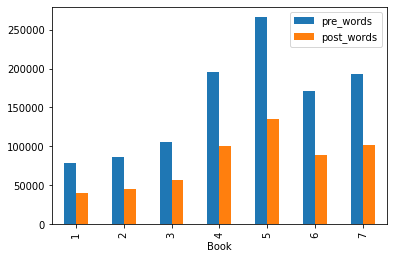

In [15]:
# nb of words before and after preprocessing per book
words_per_book = all_books.groupby(level=0).sum()
words_per_book.groupby(level=0).sum().plot.bar()

In [16]:
for book in books:
  pre_words,post_words = words_per_book.loc[book]
  print(f"book_{book} has {len(all_books.xs(book, level='Book').index.to_list())} chapters, {pre_words} words before preprocessing, {post_words} words after preprocessing")

book_1 has 17 chapters, 78426 words before preprocessing, 40563 words after preprocessing
book_2 has 19 chapters, 86625 words before preprocessing, 45956 words after preprocessing
book_3 has 22 chapters, 106048 words before preprocessing, 56358 words after preprocessing
book_4 has 37 chapters, 195438 words before preprocessing, 100683 words after preprocessing
book_5 has 38 chapters, 265641 words before preprocessing, 135628 words after preprocessing
book_6 has 30 chapters, 171569 words before preprocessing, 89062 words after preprocessing
book_7 has 37 chapters, 192368 words before preprocessing, 101941 words after preprocessing


Book
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
6    AxesSubplot(0.125,0.125;0.775x0.755)
7    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

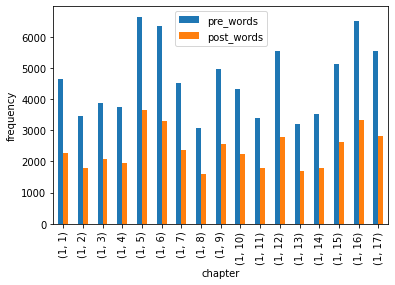

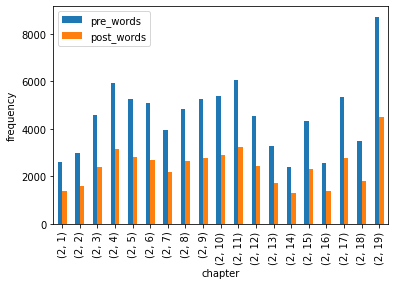

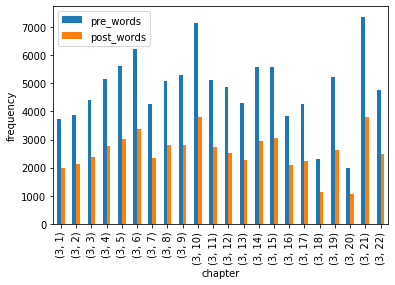

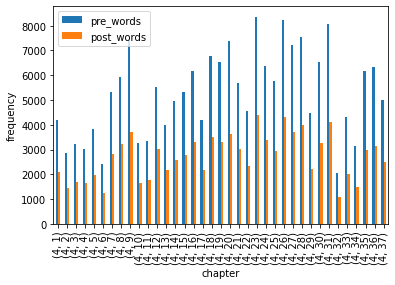

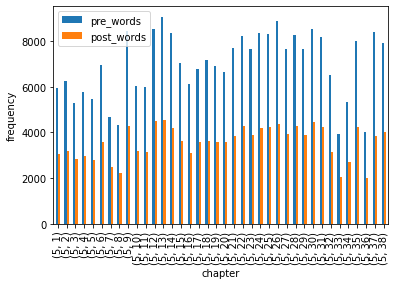

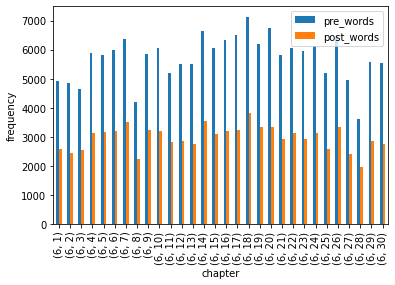

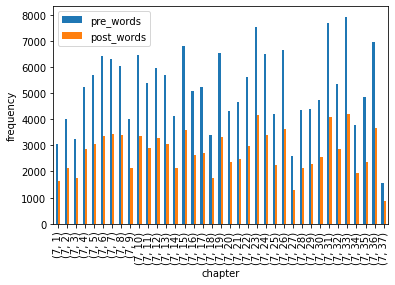

In [17]:
# nb of words per book and per chapter

all_books.groupby(level=0).plot.bar(xlabel='chapter',ylabel='frequency')

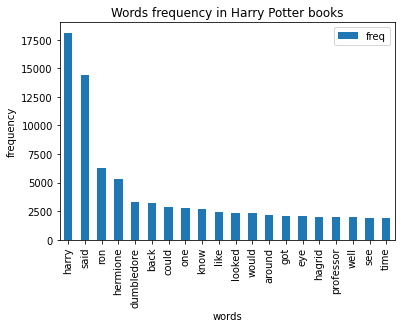

In [18]:
print_stats(all_books)

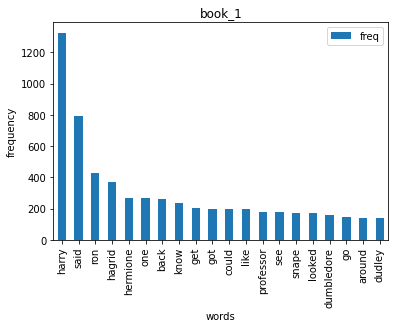

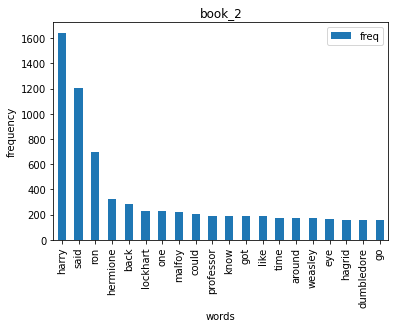

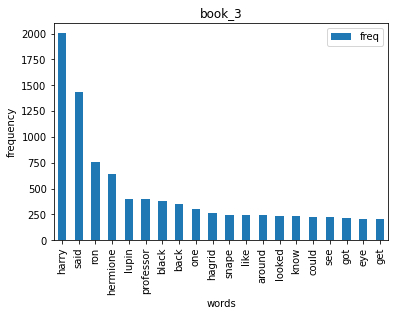

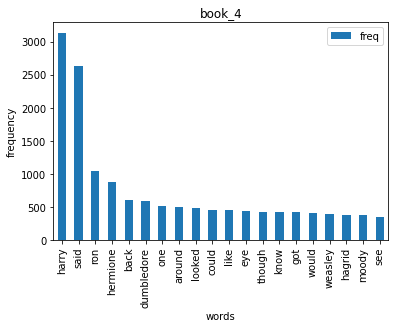

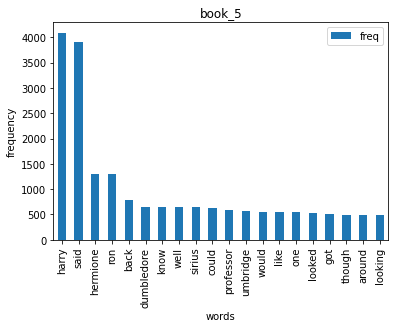

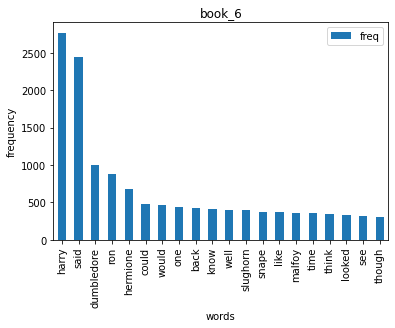

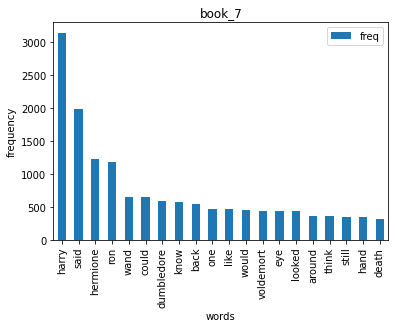

In [19]:
print_stats(all_books,mode='book')

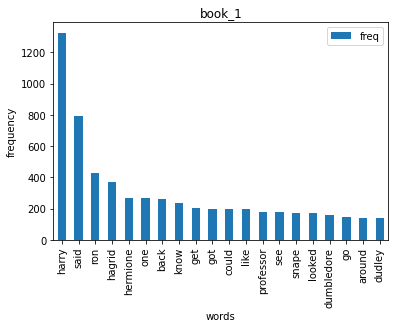

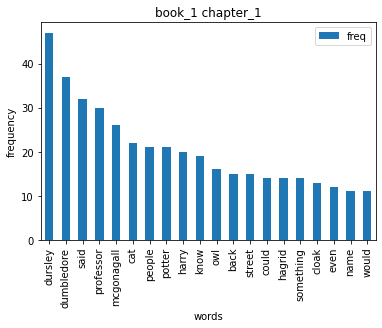

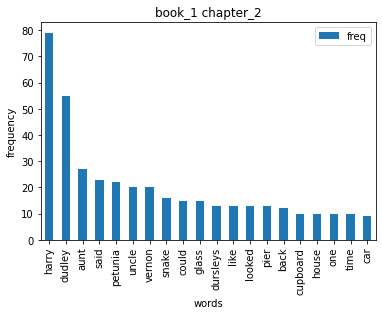

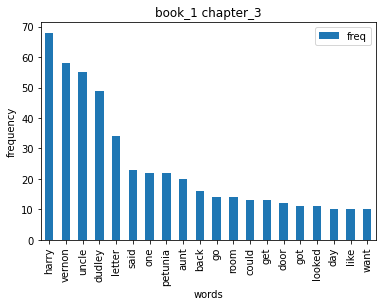

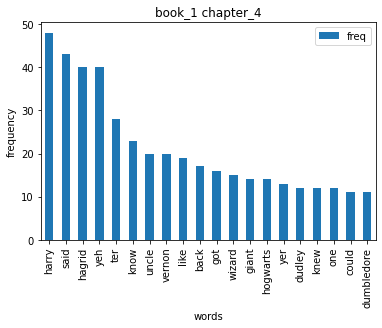

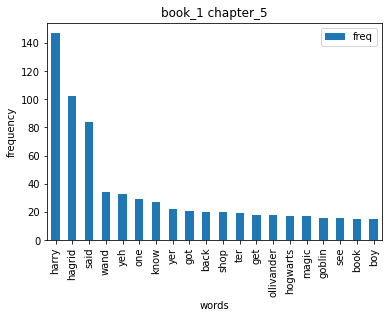

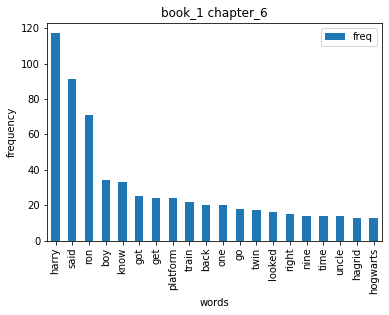

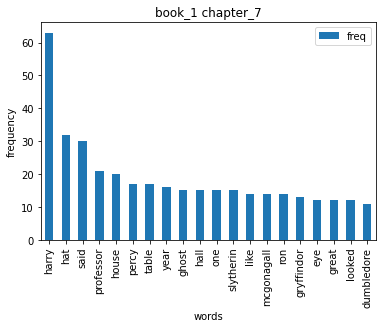

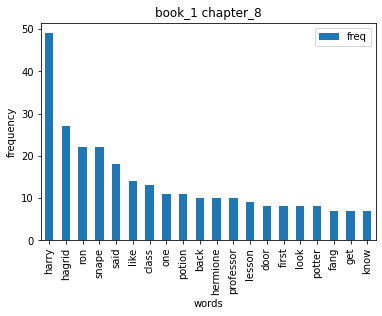

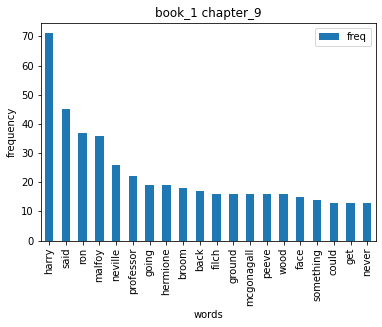

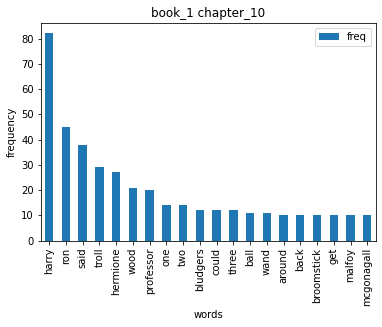

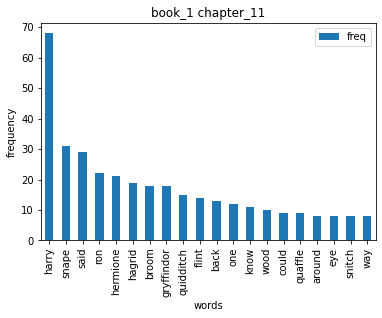

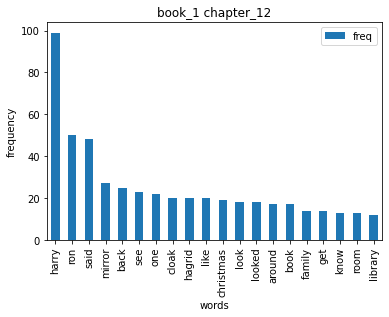

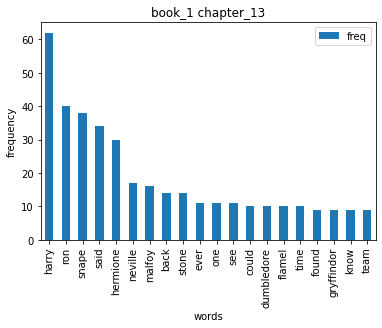

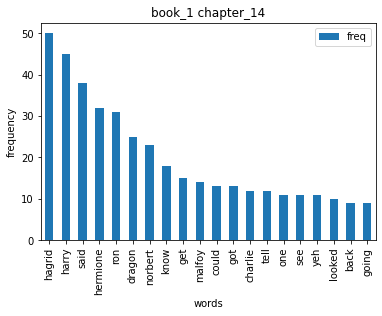

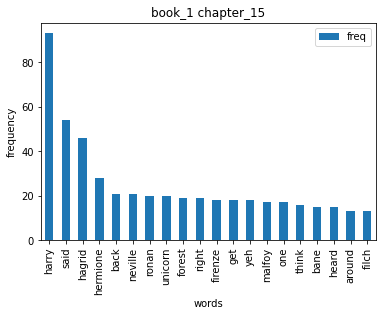

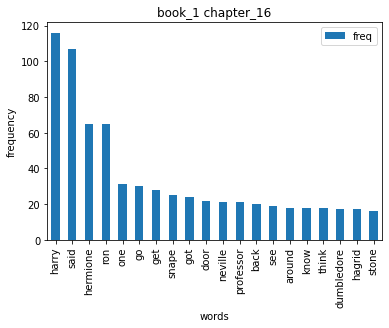

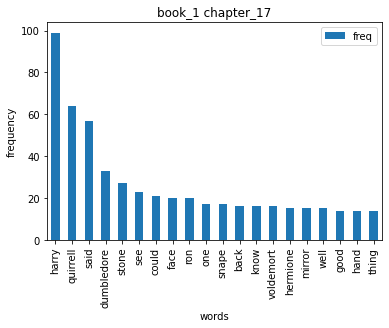

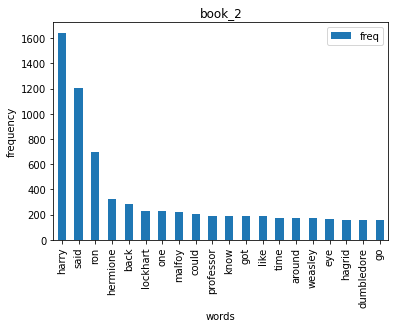

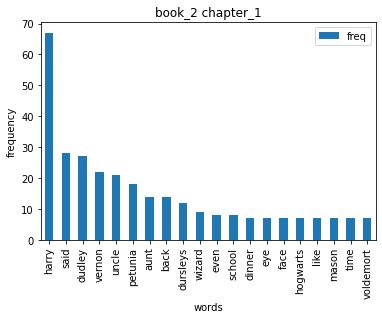

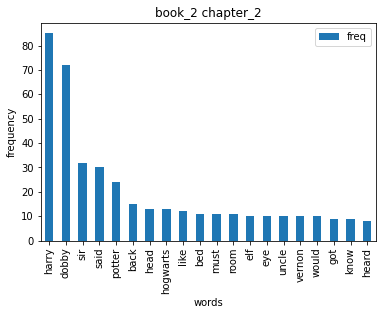

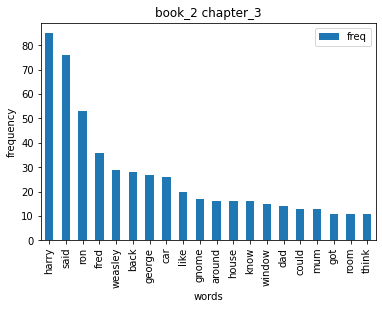

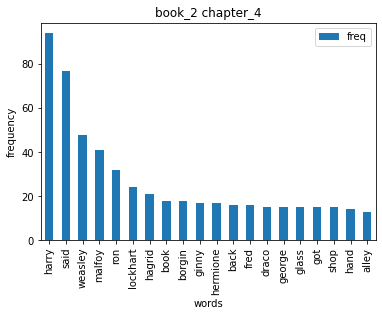

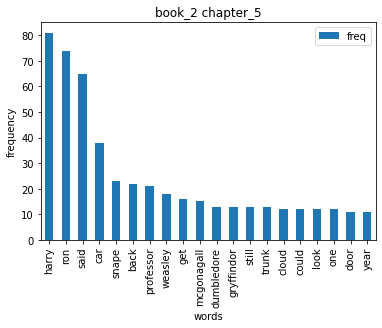

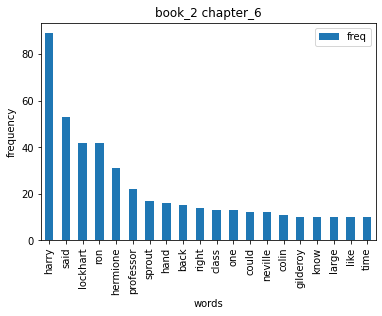

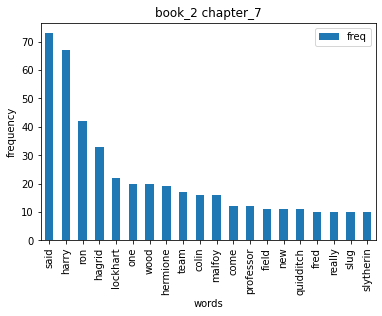

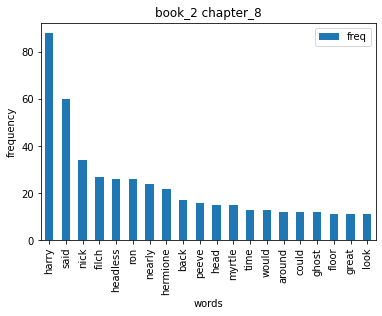

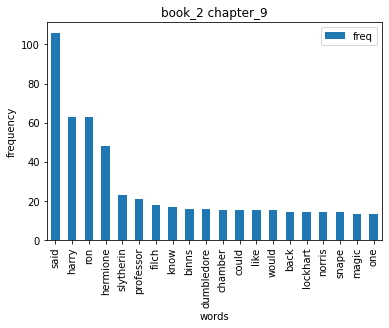

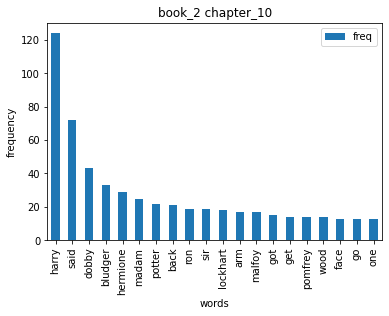

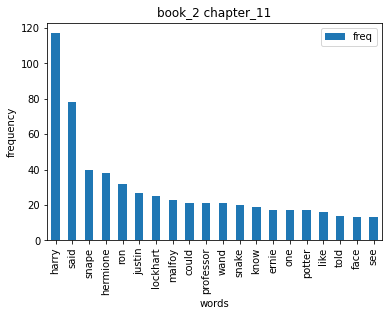

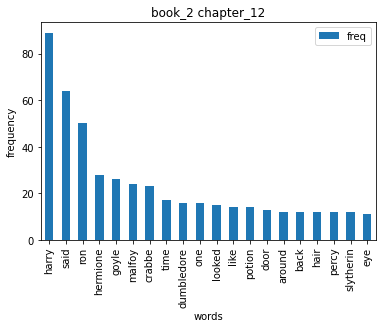

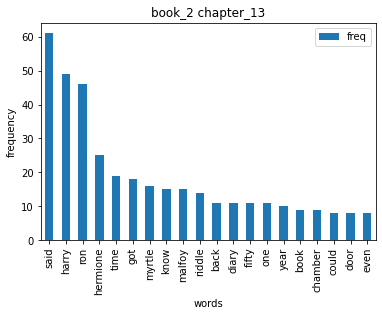

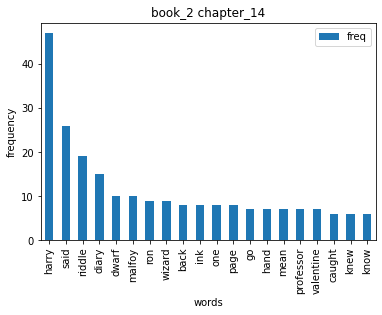

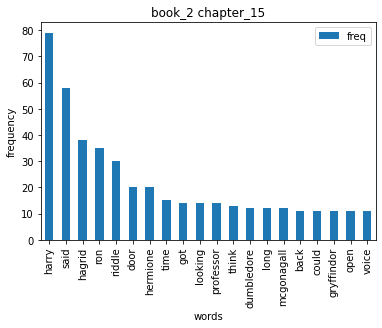

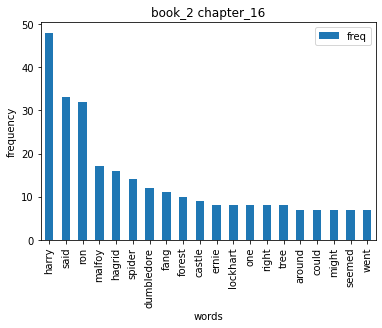

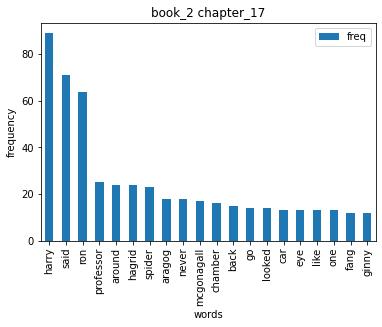

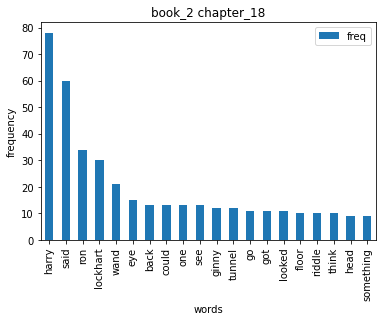

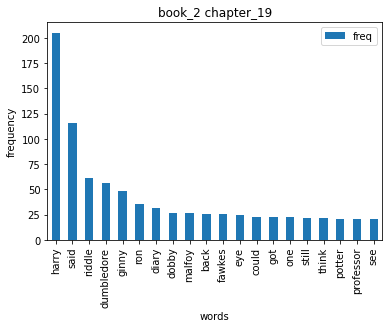

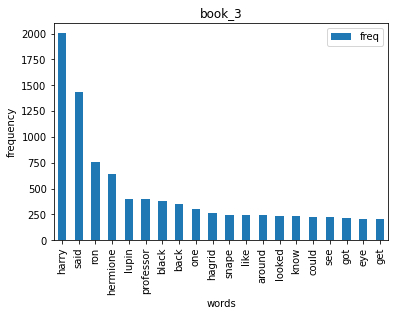

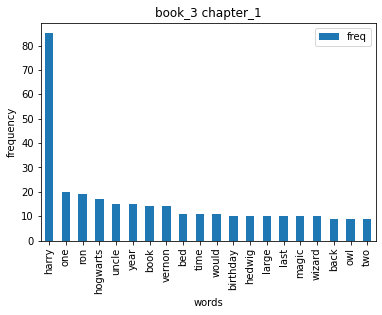

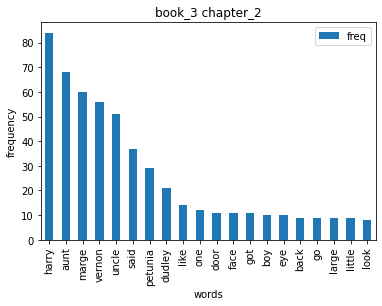

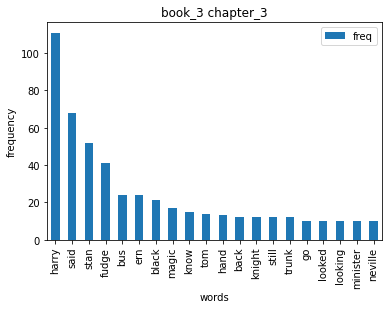

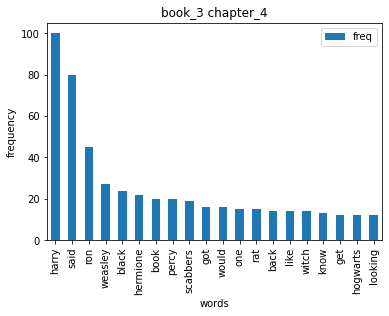

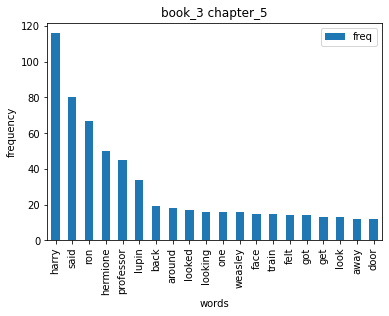

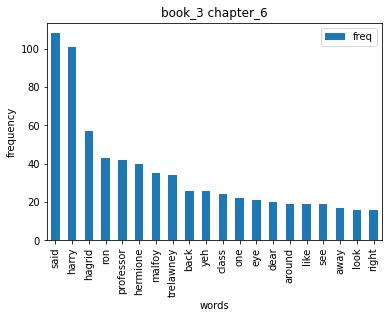

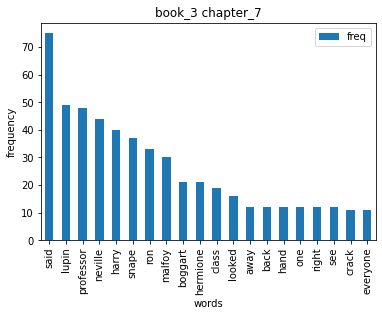

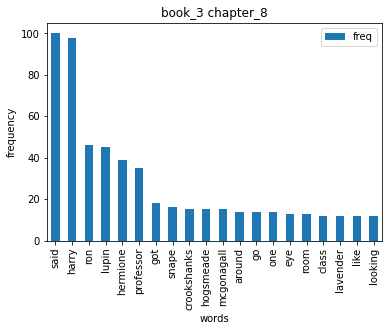

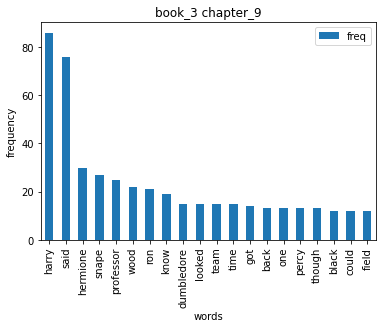

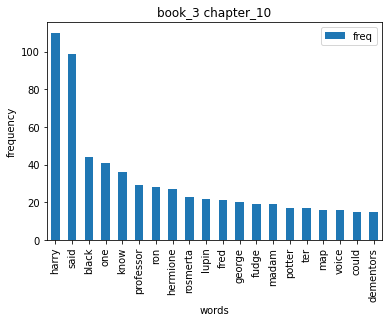

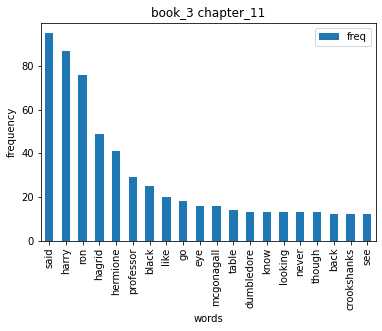

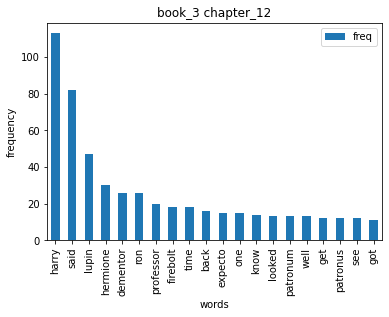

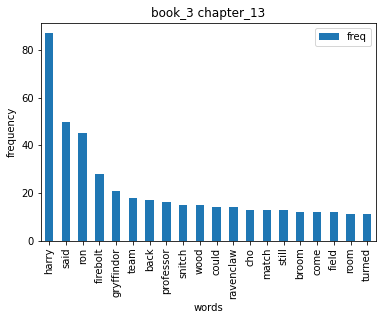

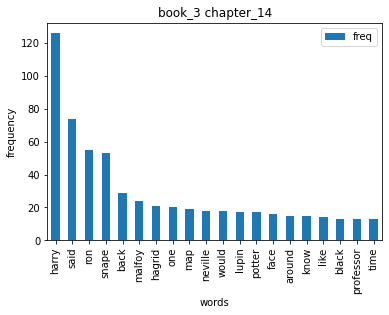

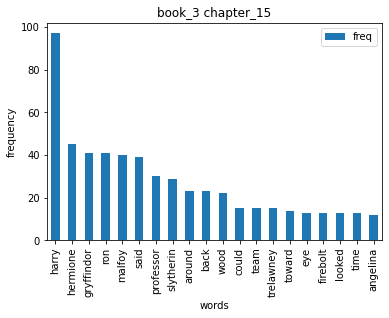

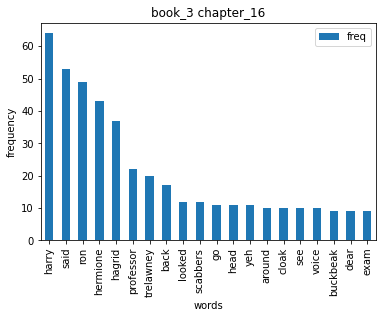

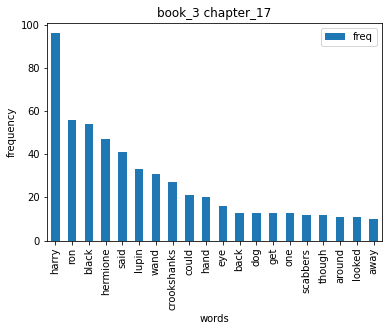

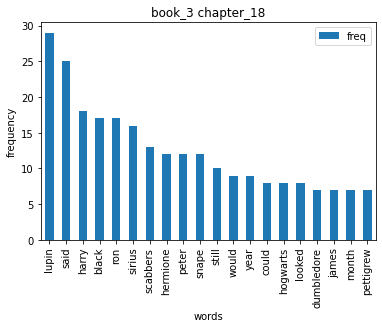

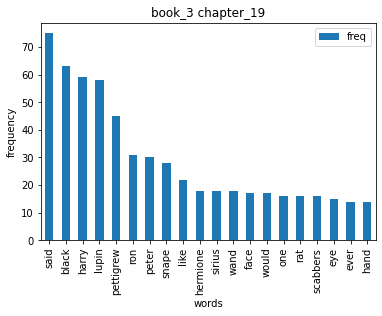

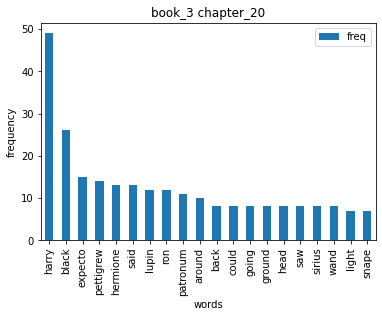

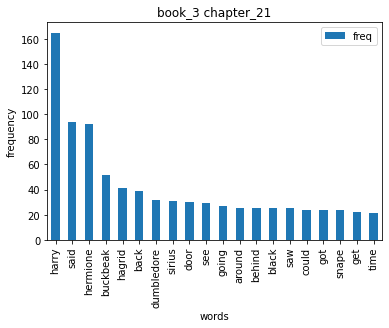

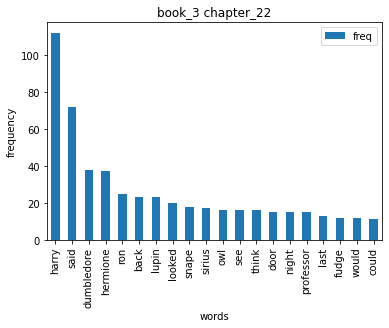

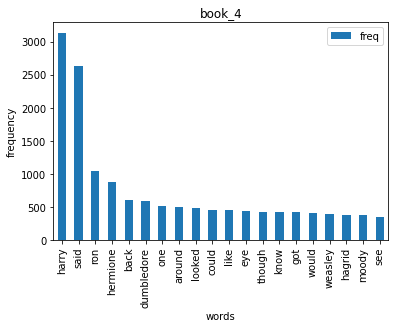

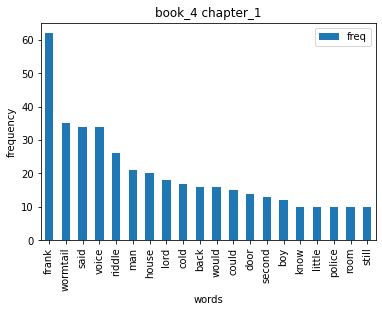

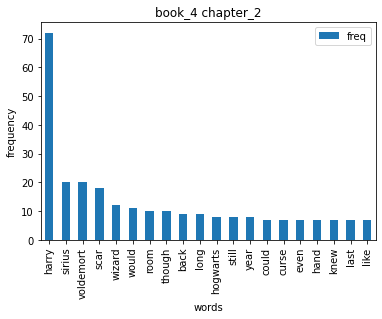

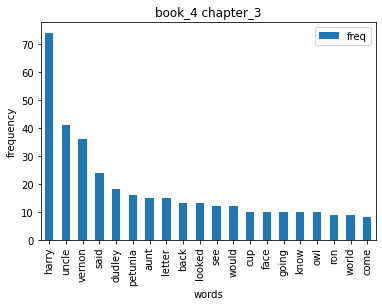

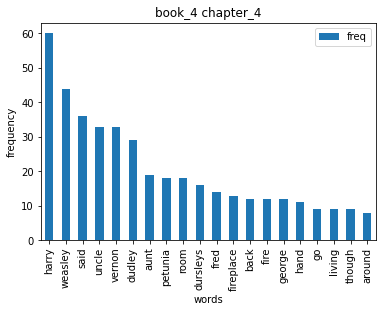

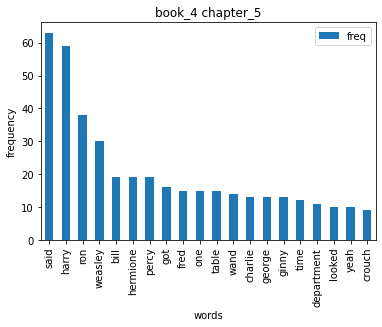

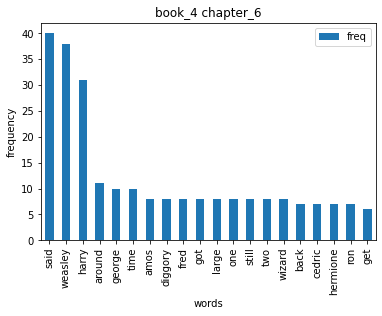

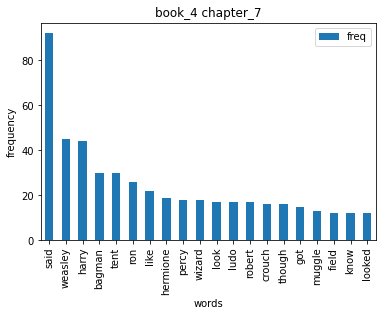

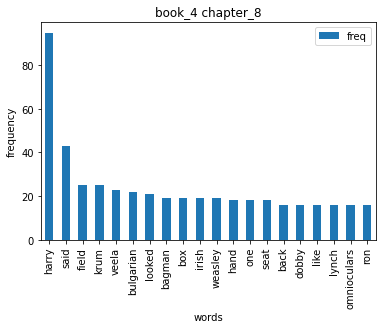

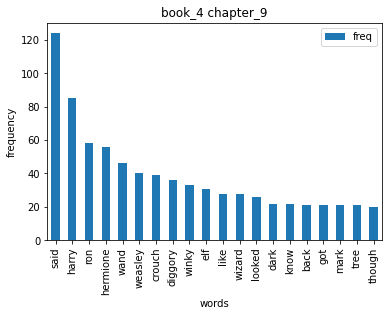

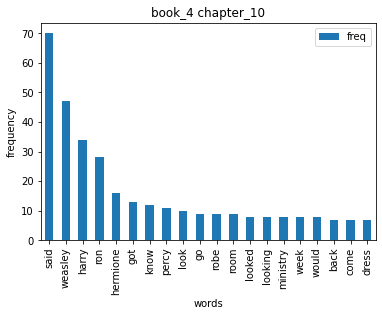

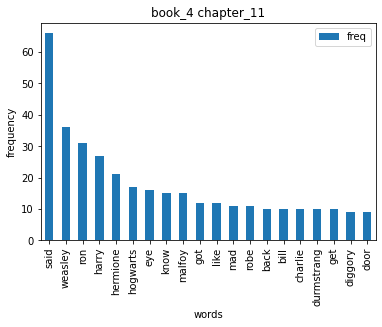

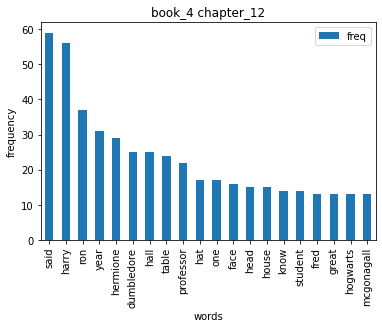

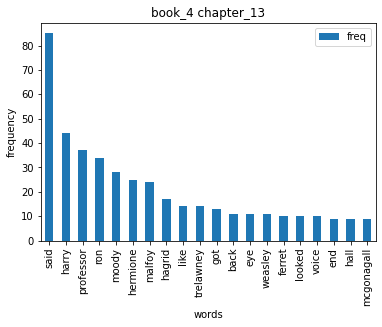

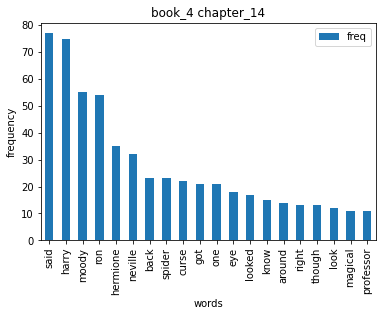

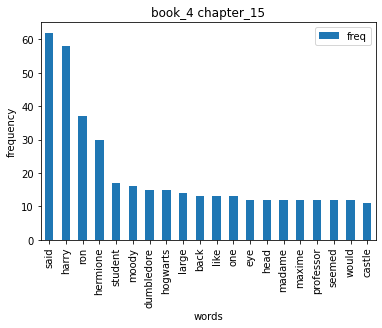

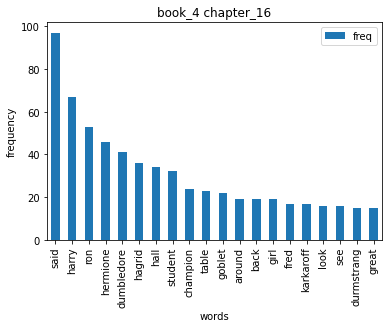

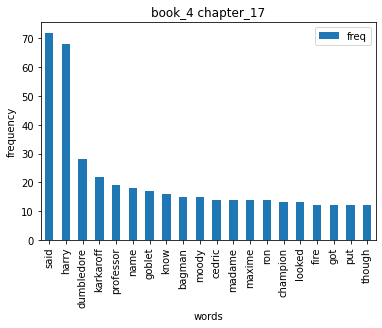

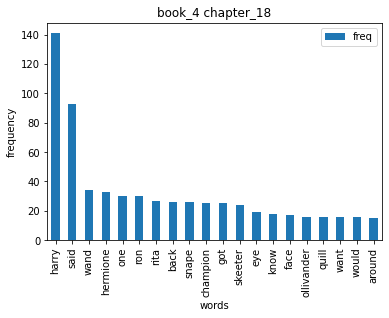

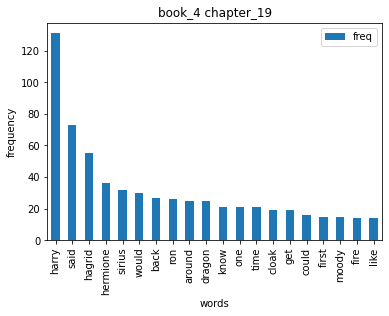

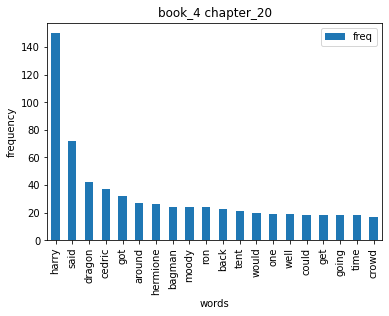

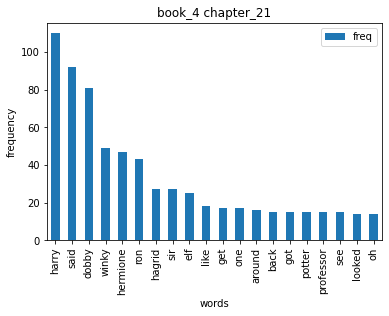

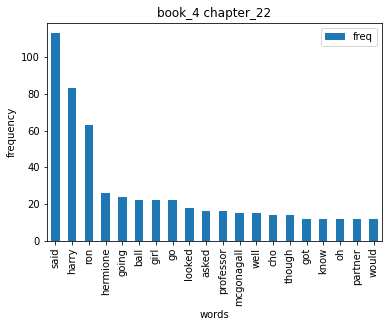

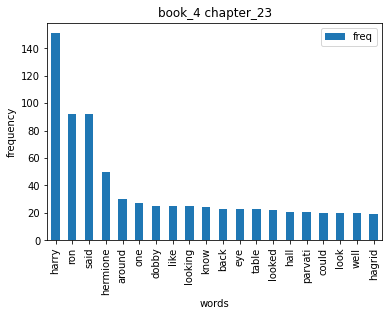

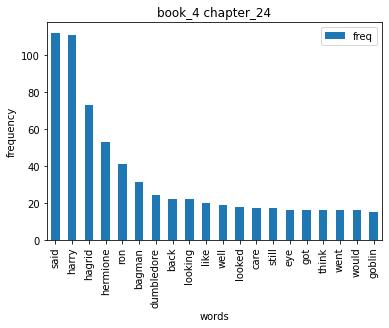

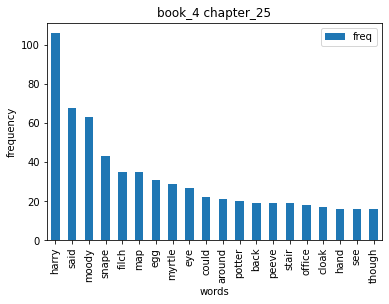

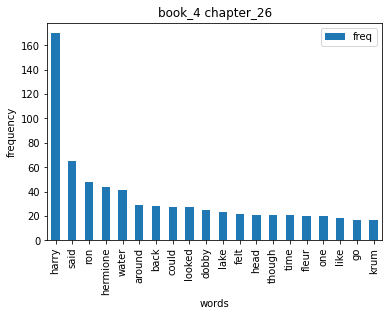

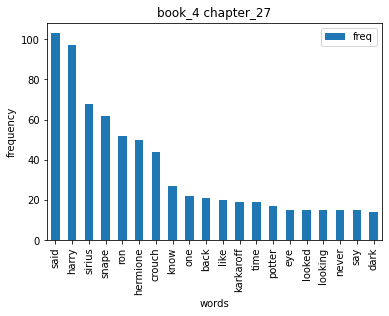

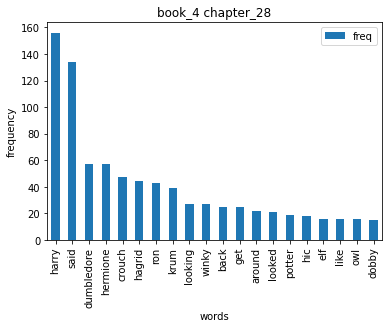

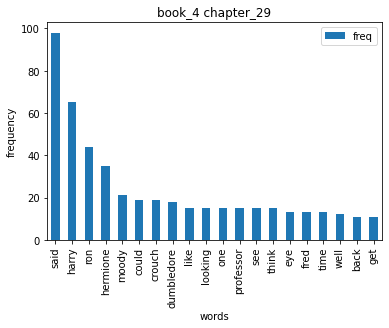

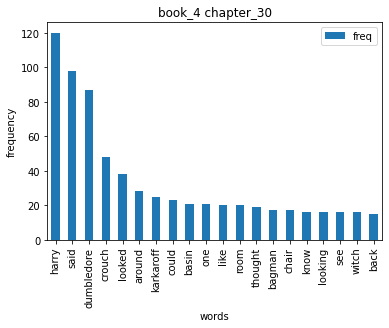

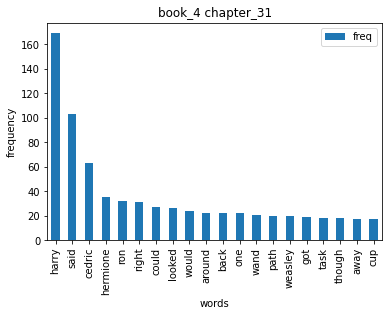

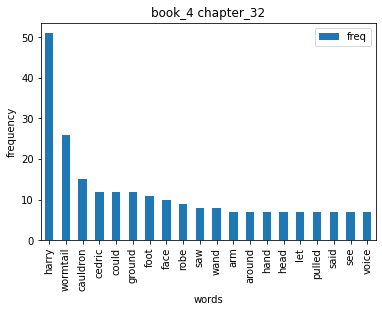

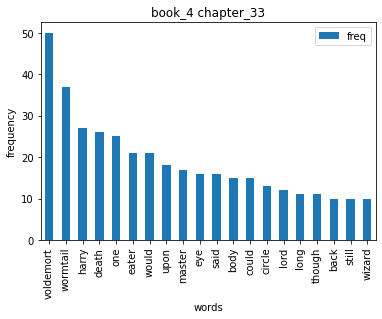

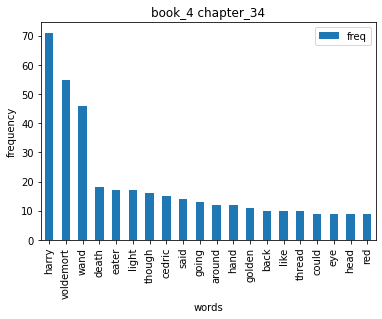

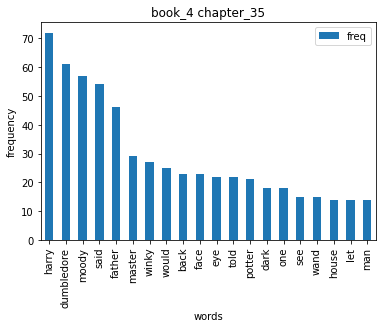

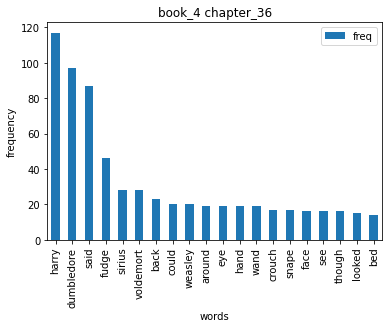

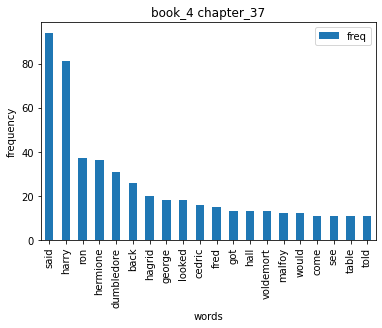

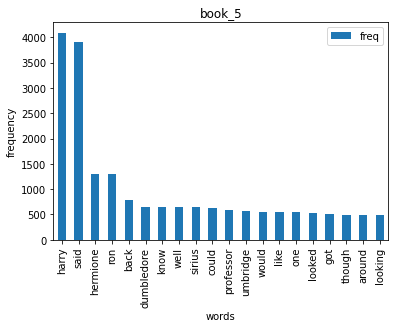

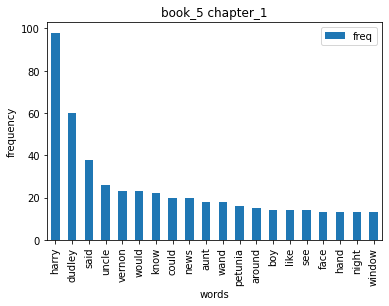

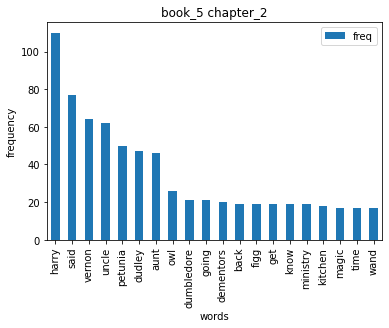

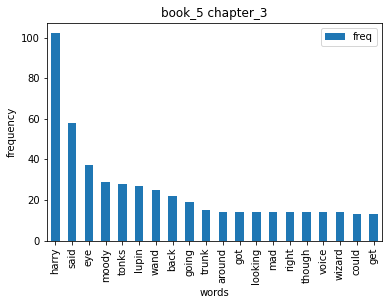

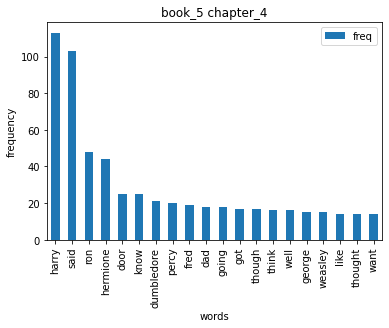

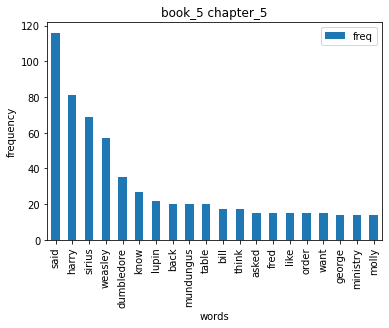

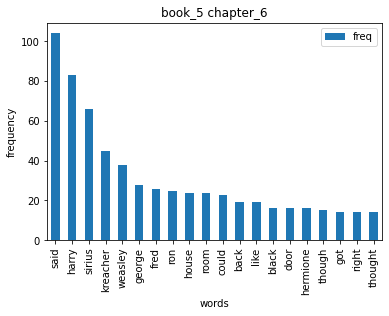

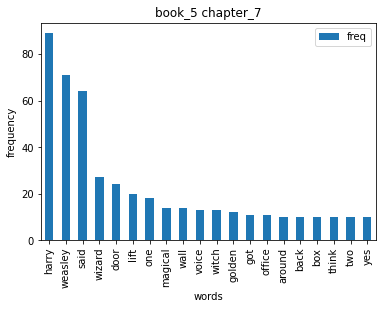

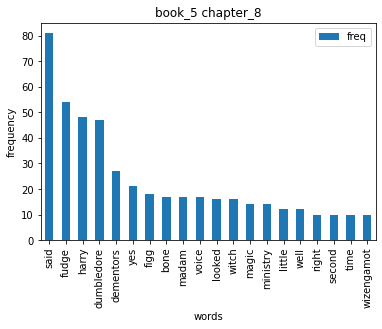

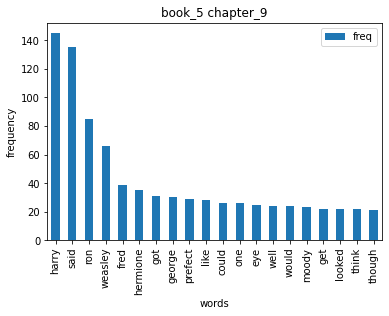

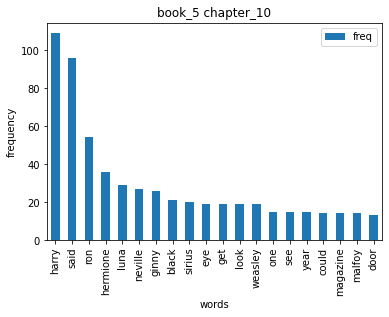

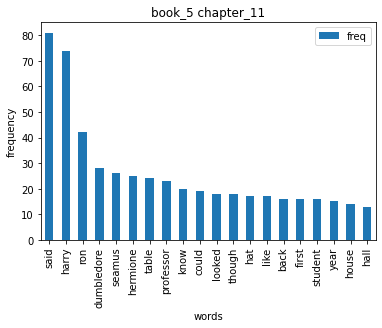

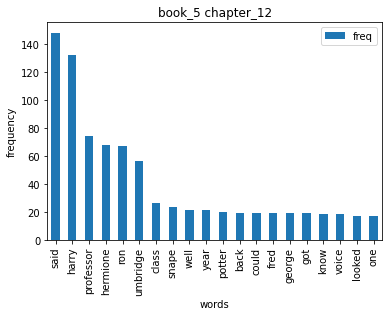

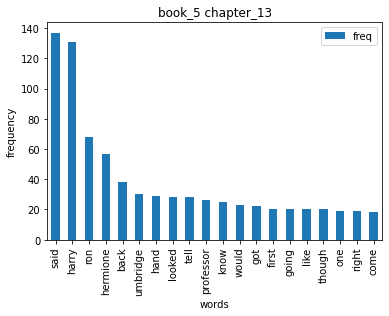

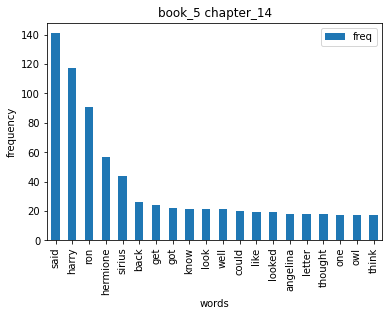

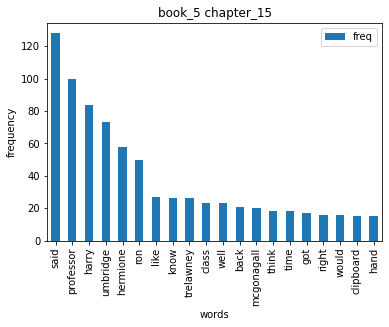

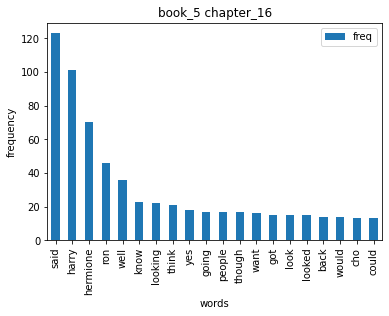

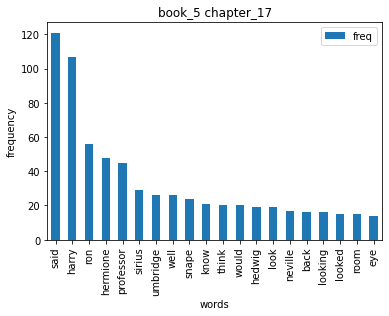

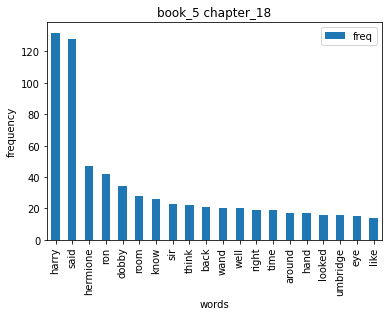

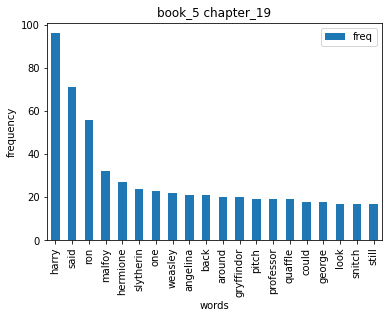

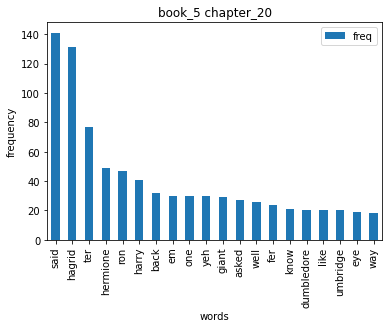

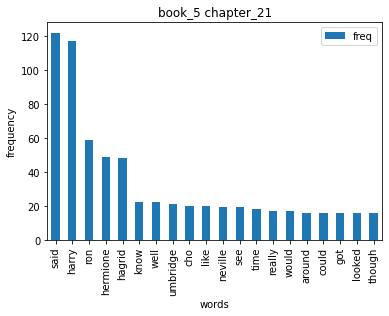

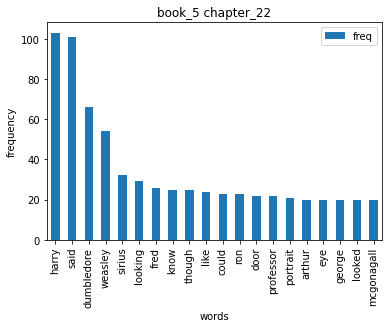

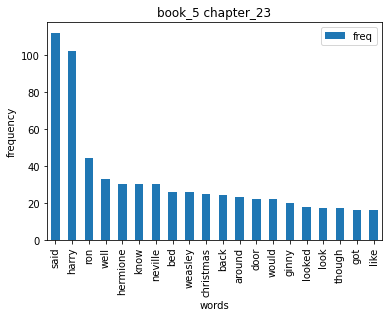

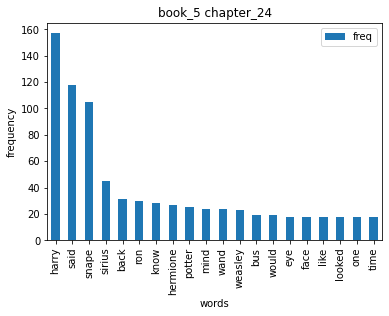

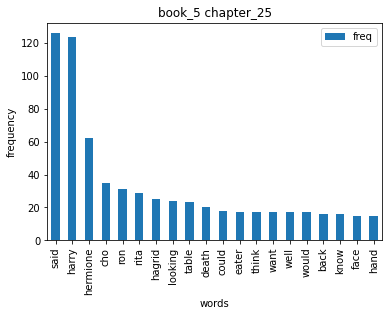

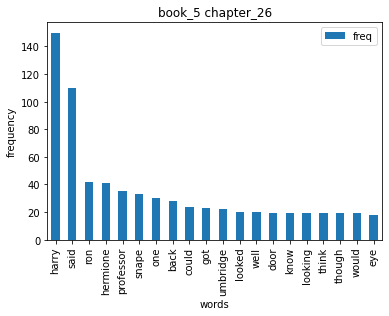

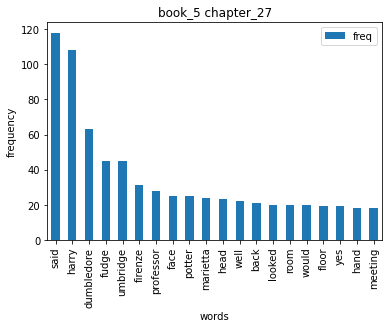

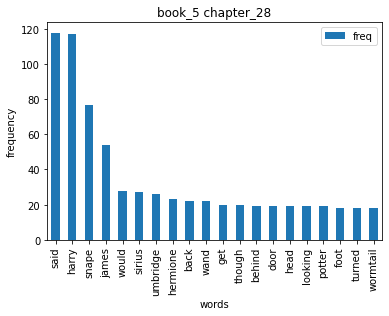

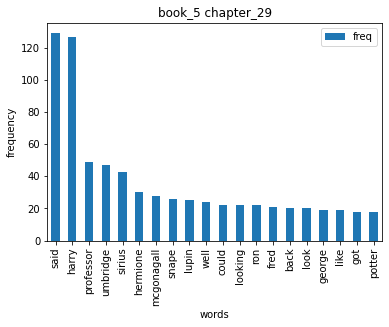

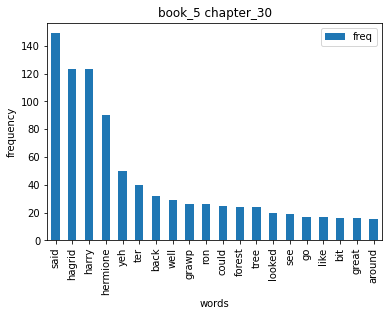

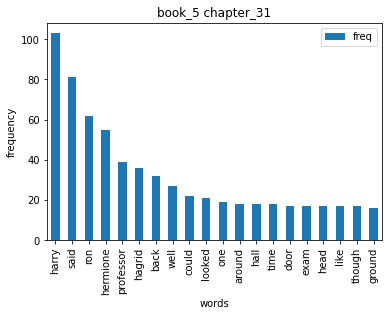

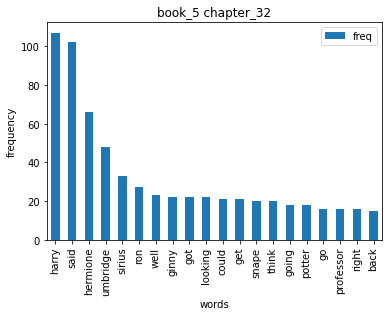

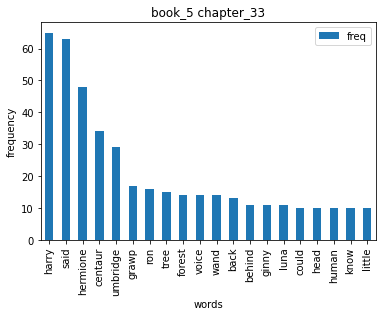

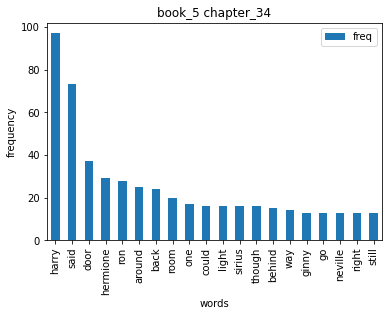

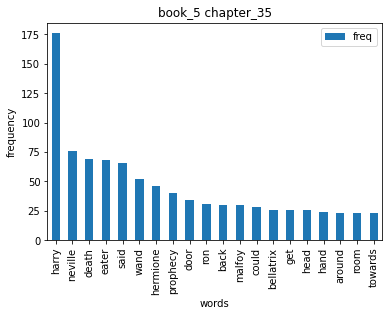

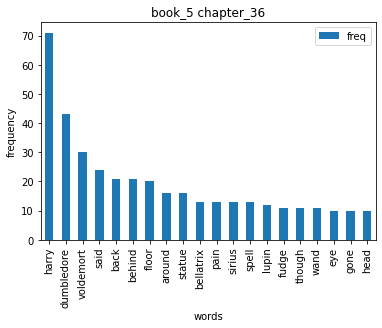

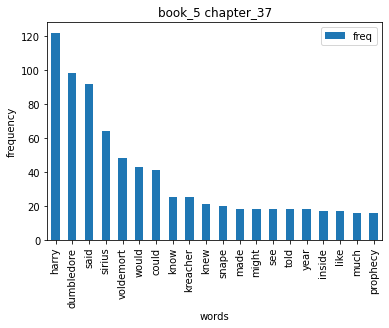

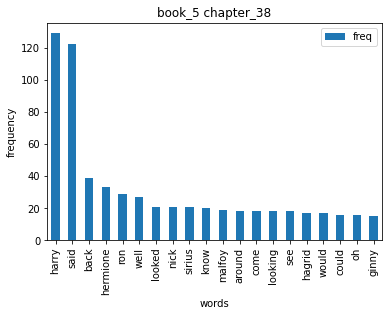

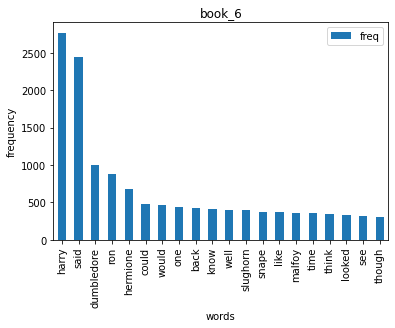

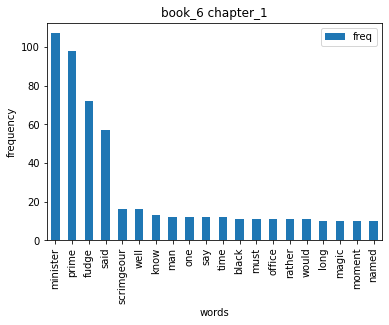

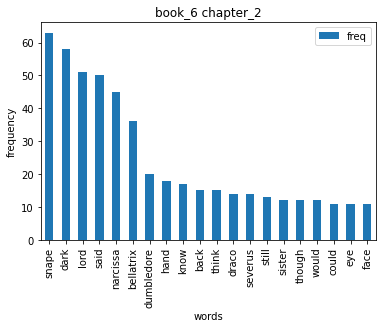

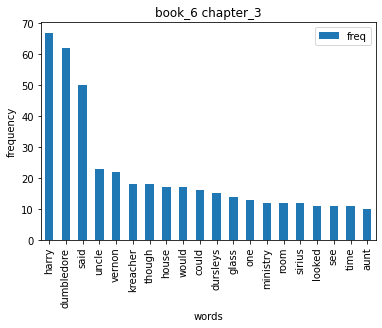

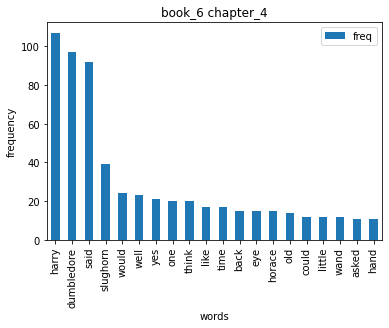

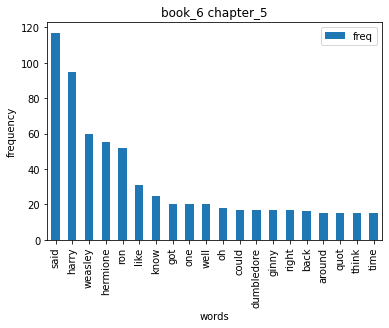

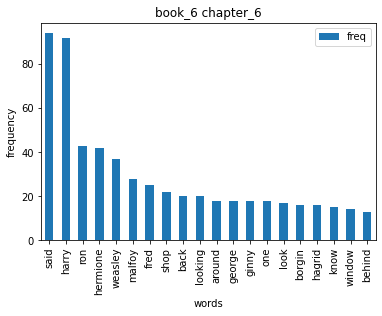

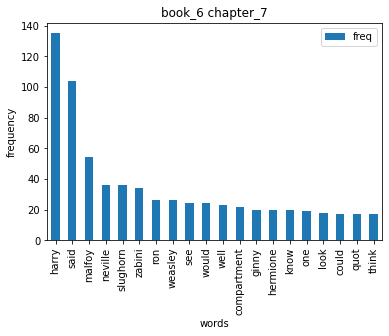

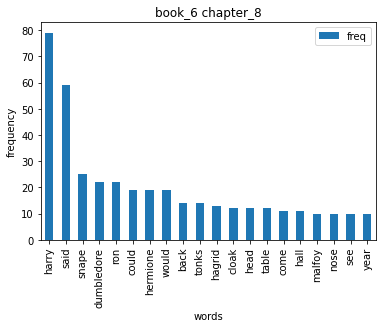

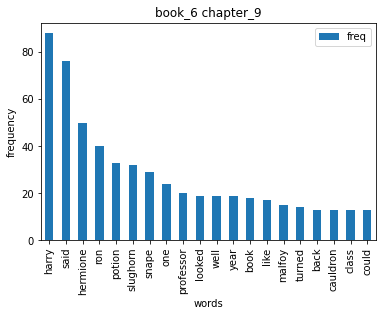

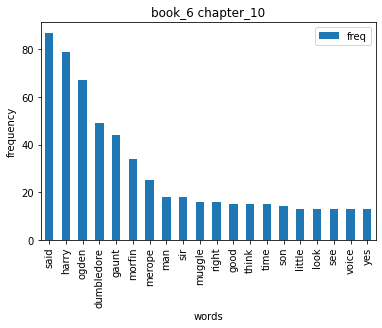

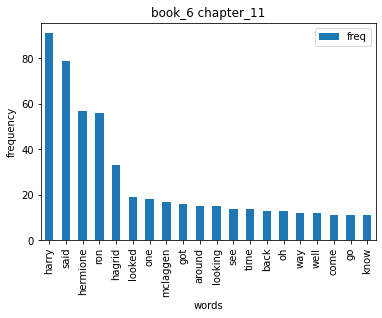

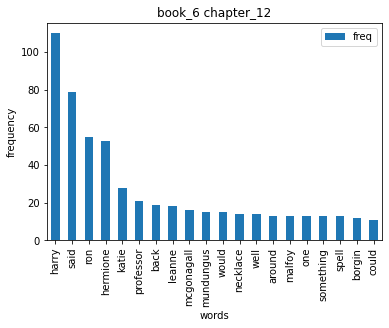

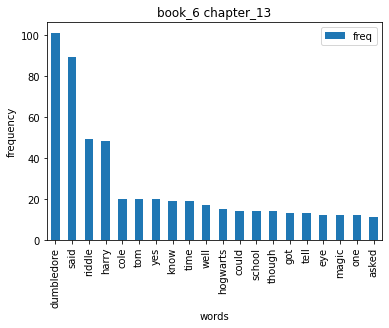

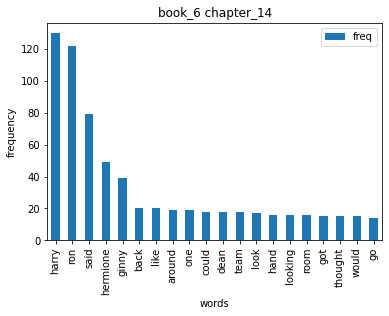

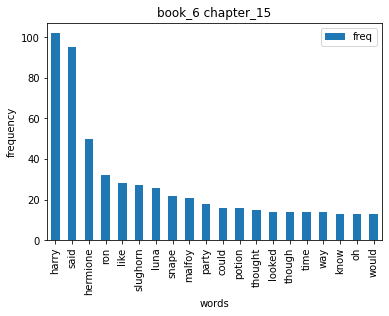

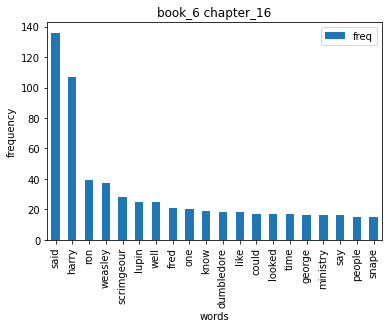

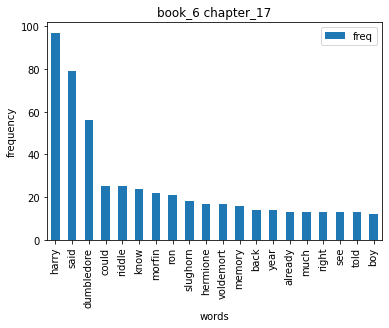

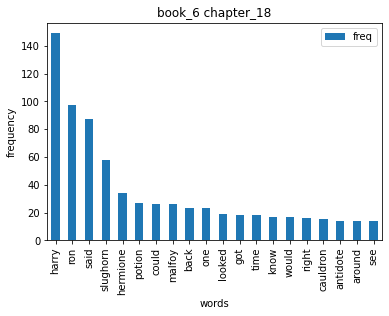

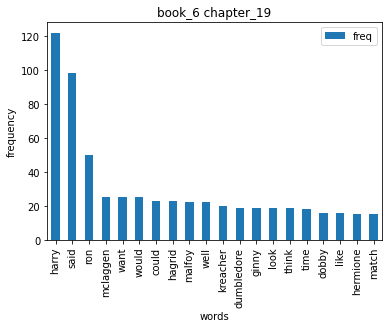

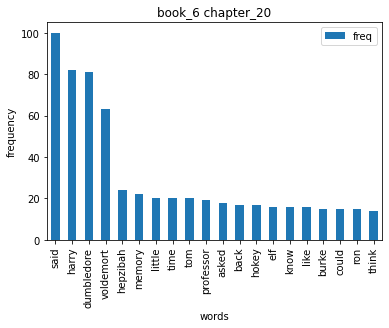

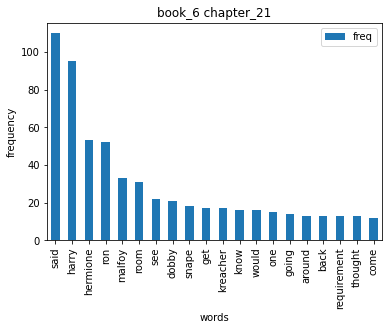

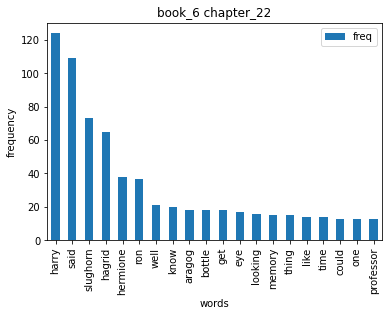

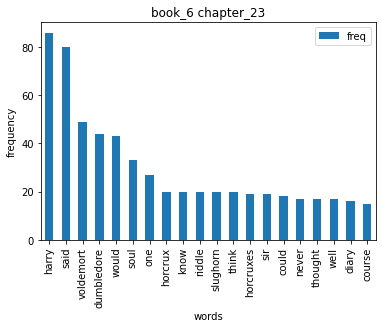

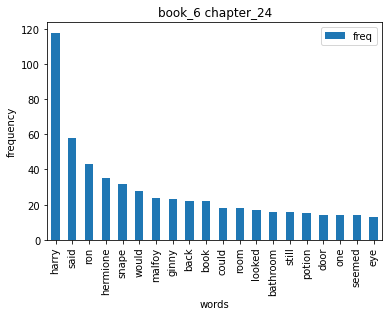

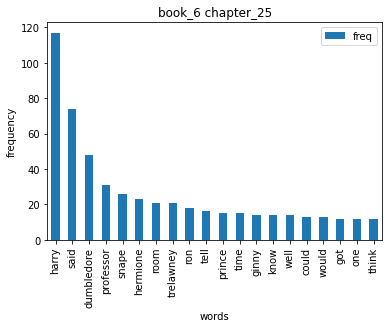

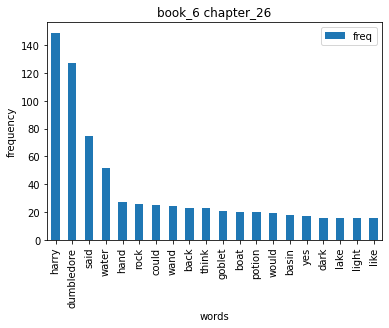

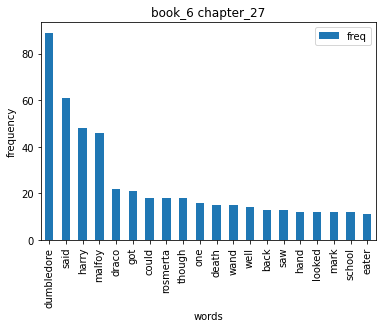

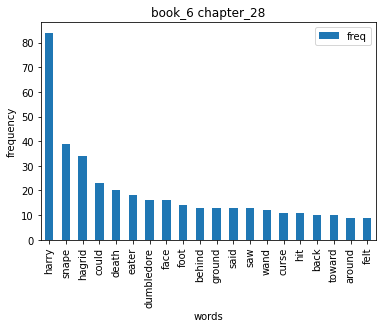

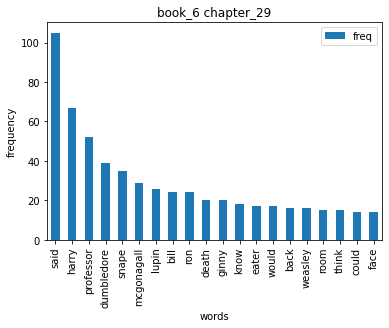

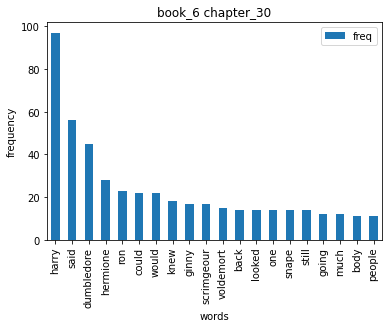

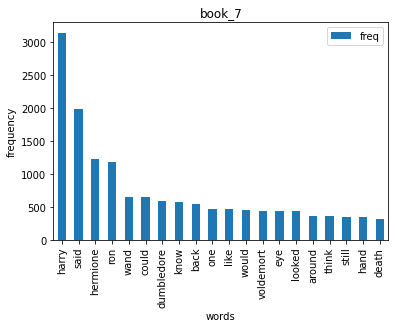

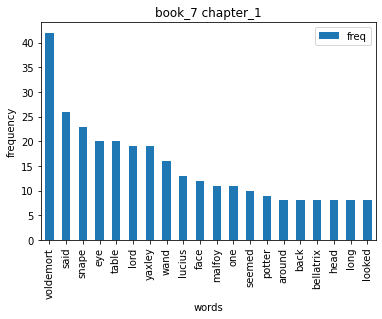

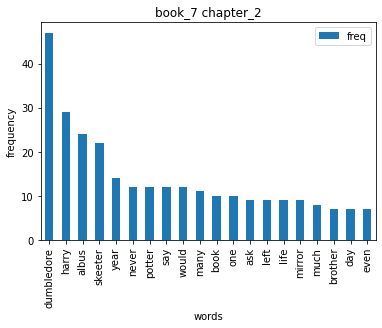

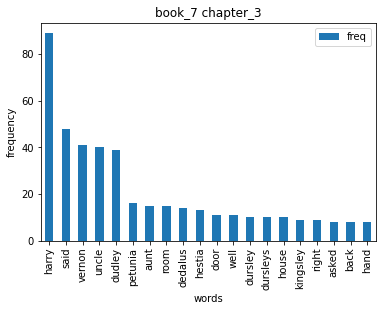

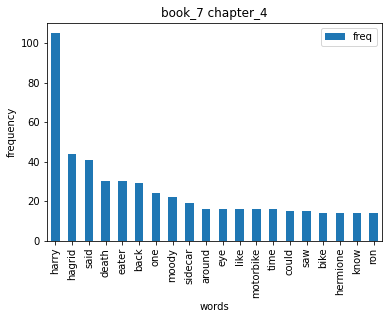

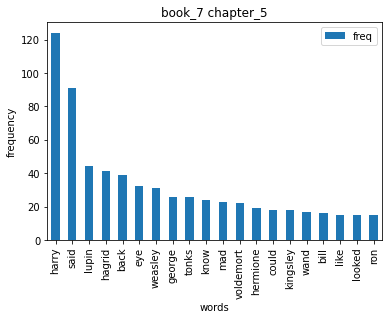

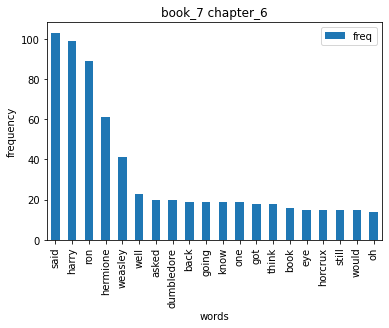

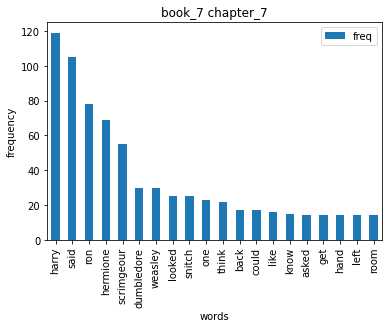

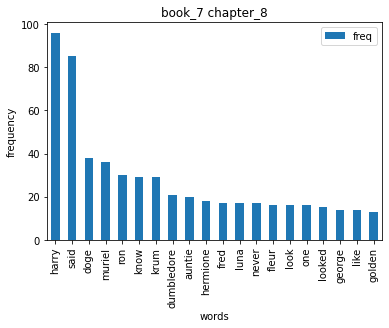

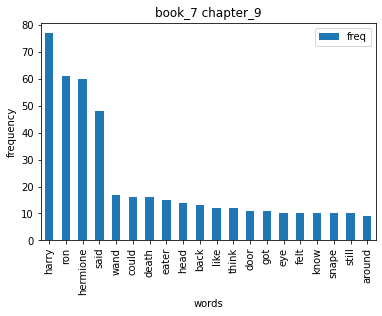

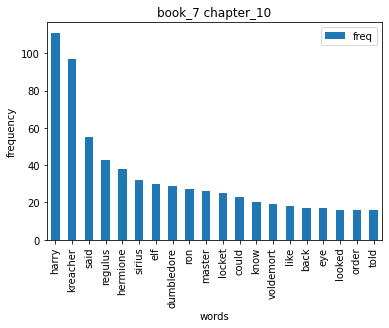

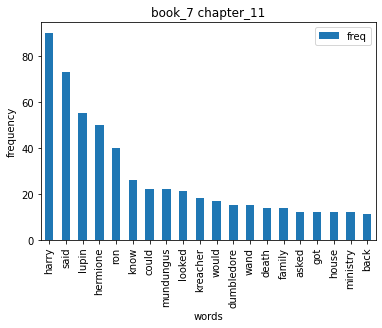

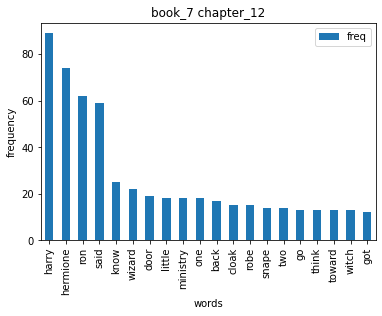

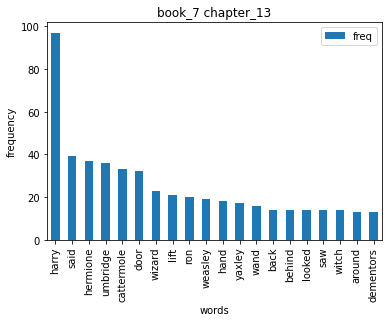

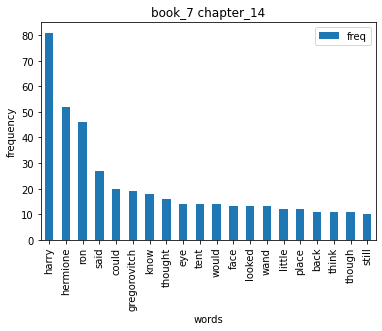

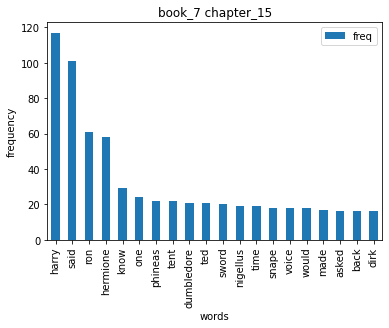

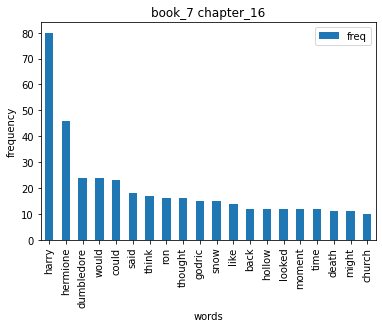

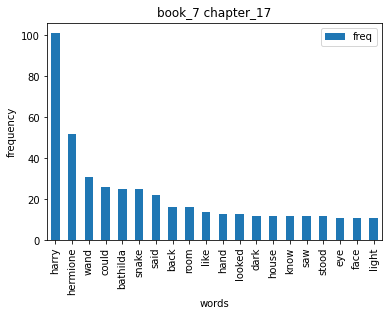

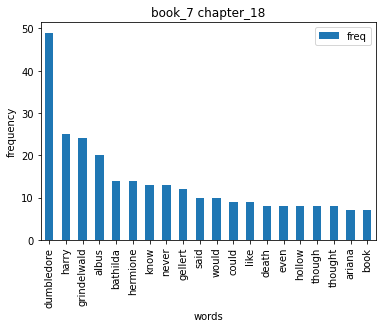

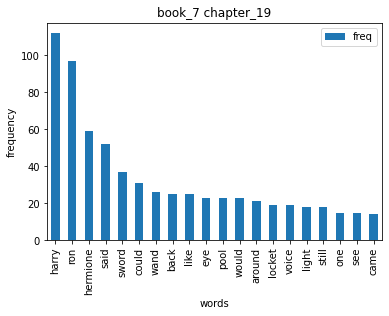

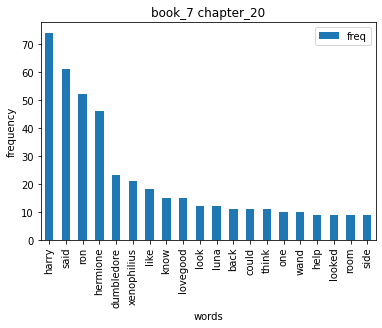

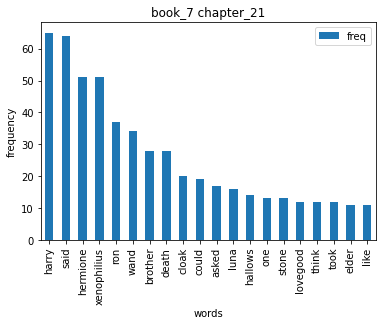

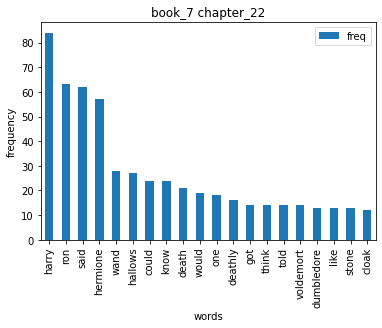

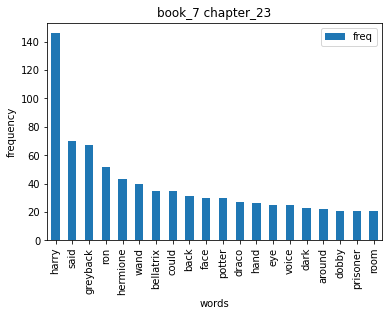

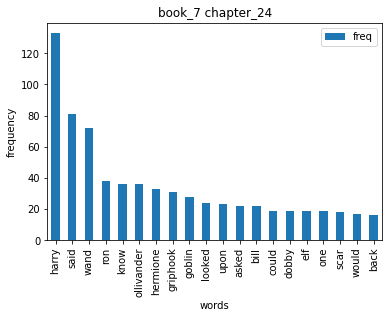

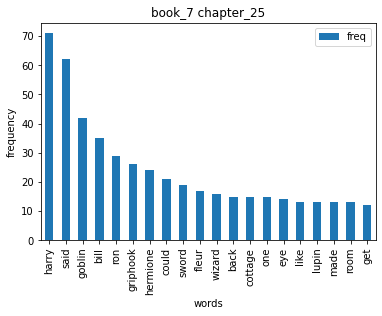

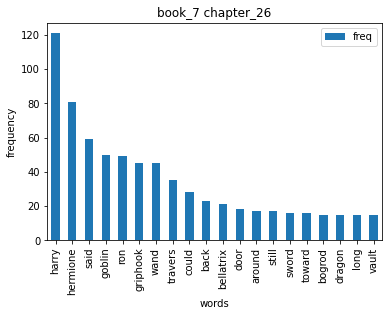

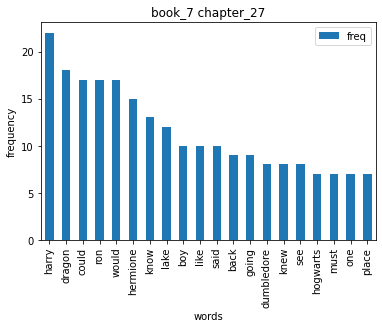

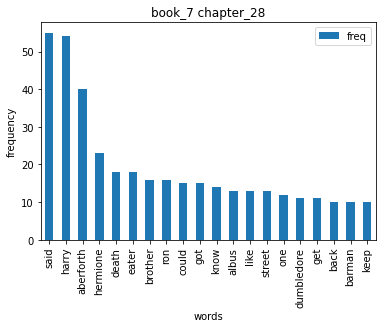

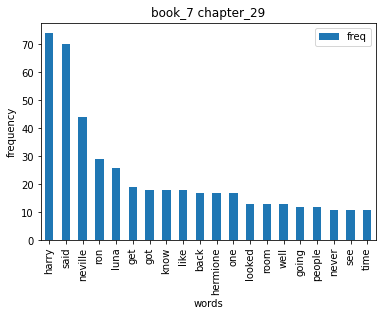

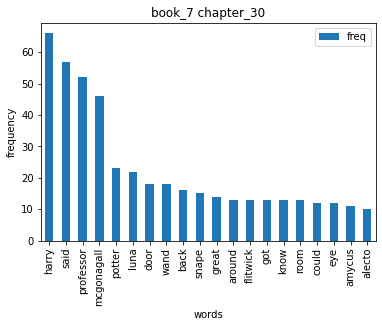

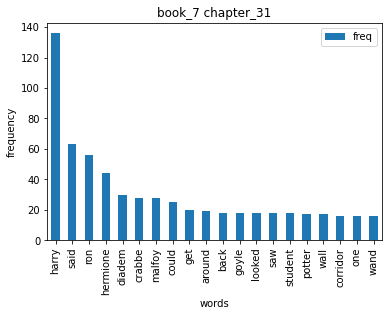

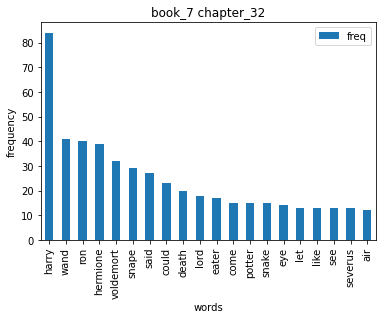

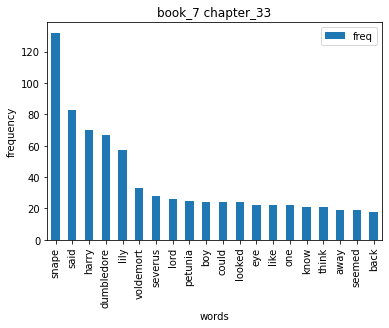

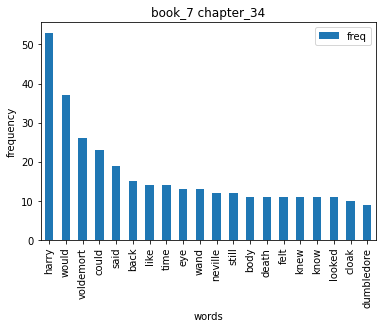

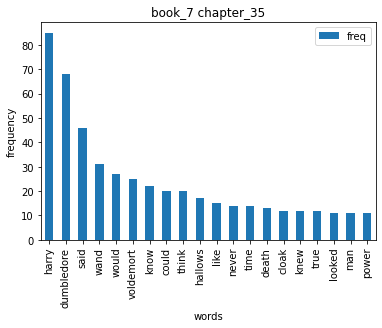

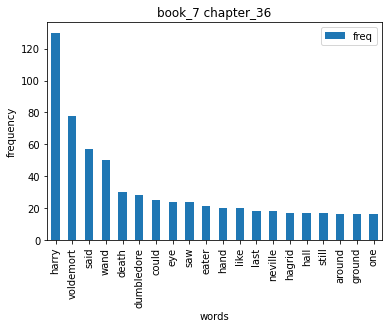

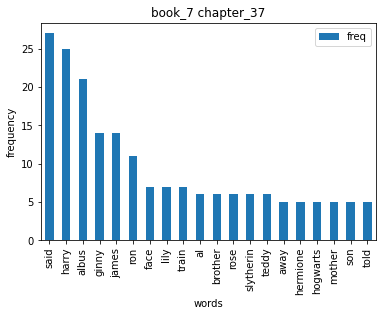

In [20]:
print_stats(all_books,mode='chapter')

## N grams

In [21]:
def count_grams(n=1,mode='book'):
  result = OrderedDict()

  if mode =='book' or mode =='all':
    texts = all_books.groupby(level='Book')['preprocessed_text'].apply(' '.join)
    for book in books:
        result[book] = 0
        g = OrderedDict()
        ngrams = nltk.ngrams(texts[book].split(),n)
        for gram in ngrams:
          if gram not in g:
            g[gram]=1
          else:
            g[gram]+=1
        g = sorted(g.items(),key=lambda x:x[1],reverse=True)
        result[book] = g
  if mode == 'chapter' or mode =='all':
    for (book,chapter) in books_chapters:
      name='book_{}_chapter_{}'.format(book,chapter)
      result[name] = 0
      g = OrderedDict()
      ngrams = nltk.ngrams(all_books.loc[(book,chapter),'preprocessed_text'].split(),n)
      for gram in ngrams:
          if gram not in g:
            g[gram]=1
          else:
            g[gram]+=1
      g = sorted(g.items(),key=lambda x:x[1],reverse=True)[:5]
      result[name] = g
  return result

def visualize_grams(books,length=5):
  for book in books:
    print('book ',book,books[book][:length])

def find_gram(grams,query):
  result = {}
  for book in grams:
    result[book] = 0
    for gram in grams[book]:
      if ' '.join(gram[0]) == query or ' '.join(gram[0][::-1]) == query:
        result[book] +=gram[1]
  return pd.Series(result)


In [22]:
# grams per book

_1grams = count_grams(n=1)
_2grams = count_grams(n=2)
_3grams = count_grams(n=3)
_4grams = count_grams(n=4)
_5grams = count_grams(n=5)
_6grams = count_grams(n=6)

In [23]:
visualize_grams(_2grams)

book  1 [(('said', 'harry'), 143), (('said', 'ron'), 111), (('uncle', 'vernon'), 108), (('professor', 'mcgonagall'), 95), (('said', 'hagrid'), 91)]
book  2 [(('said', 'harry'), 229), (('said', 'ron'), 206), (('harry', 'ron'), 96), (('professor', 'mcgonagall'), 85), (('harry', 'potter'), 79)]
book  3 [(('said', 'harry'), 256), (('said', 'ron'), 175), (('said', 'hermione'), 122), (('professor', 'lupin'), 118), (('ron', 'hermione'), 106)]
book  4 [(('said', 'harry'), 437), (('said', 'ron'), 307), (('said', 'hermione'), 215), (('harry', 'said'), 162), (('ron', 'hermione'), 151)]
book  5 [(('said', 'harry'), 701), (('said', 'hermione'), 417), (('said', 'ron'), 345), (('harry', 'said'), 191), (('professor', 'umbridge'), 186)]
book  6 [(('said', 'harry'), 535), (('said', 'dumbledore'), 285), (('said', 'ron'), 195), (('said', 'hermione'), 182), (('harry', 'said'), 113)]
book  7 [(('said', 'harry'), 406), (('said', 'ron'), 239), (('said', 'hermione'), 225), (('death', 'eater'), 203), (('ron', '

In [24]:
visualize_grams(_3grams)

book  1 [(('said', 'professor', 'mcgonagall'), 16), (('nimbus', 'two', 'thousand'), 15), (('said', 'uncle', 'vernon'), 13), (('harry', 'could', 'see'), 10), (('harry', 'ron', 'hermione'), 10)]
book  2 [(('nearly', 'headless', 'nick'), 33), (('said', 'professor', 'mcgonagall'), 21), (('harry', 'ron', 'hermione'), 19), (('harry', 'could', 'see'), 14), (('moaning', 'myrtle', 'bathroom'), 12)]
book  3 [(('harry', 'ron', 'hermione'), 44), (('said', 'professor', 'mcgonagall'), 27), (('said', 'professor', 'lupin'), 23), (('defense', 'dark', 'art'), 22), (('yes', 'said', 'harry'), 12)]
book  4 [(('harry', 'ron', 'hermione'), 74), (('quidditch', 'world', 'cup'), 33), (('harry', 'could', 'see'), 28), (('yeah', 'said', 'harry'), 27), (('harry', 'looked', 'around'), 24)]
book  5 [(('yeah', 'said', 'harry'), 45), (('defence', 'dark', 'art'), 45), (('harry', 'ron', 'hermione'), 42), (('said', 'professor', 'mcgonagall'), 42), (('said', 'professor', 'umbridge'), 36)]
book  6 [(('harry', 'ron', 'hermio

In [25]:
visualize_grams(_4grams)

book  1 [(('platform', 'nine', 'three', 'quarter'), 7), (('vault', 'seven', 'hundred', 'thirteen'), 6), (('bott', 'every', 'flavor', 'bean'), 4), (('uncle', 'vernon', 'aunt', 'petunia'), 3), (('hogwarts', 'school', 'witchcraft', 'wizardry'), 3)]
book  2 [(('said', 'nearly', 'headless', 'nick'), 7), (('hogwarts', 'school', 'witchcraft', 'wizardry'), 5), (('justin', 'nearly', 'headless', 'nick'), 5), (('defense', 'dark', 'art', 'teacher'), 4), (('harry', 'potter', 'said', 'riddle'), 4)]
book  3 [(('uncle', 'vernon', 'aunt', 'petunia'), 6), (('defense', 'dark', 'art', 'teacher'), 6), (('committee', 'disposal', 'dangerous', 'creature'), 6), (('moony', 'wormtail', 'padfoot', 'prong'), 5), (('expecto', 'patronum', 'expecto', 'patronum'), 4)]
book  4 [(('department', 'international', 'magical', 'cooperation'), 7), (('said', 'nearly', 'headless', 'nick'), 7), (('put', 'name', 'goblet', 'fire'), 7), (('uncle', 'vernon', 'aunt', 'petunia'), 6), (('department', 'regulation', 'control', 'magical')

In [26]:
visualize_grams(_5grams)

book  1 [(('one', 'thousand', 'magical', 'herb', 'fungi'), 3), (('bettie', 'bott', 'every', 'flavor', 'bean'), 3), (('often', 'said', 'dudley', 'looked', 'like'), 2), (('read', 'hogwarts', 'school', 'witchcraft', 'wizardry'), 2), (('say', 'died', 'codswallop', 'opinion', 'dunno'), 2)]
book  2 [(('witch', 'weekly', 'charming', 'smile', 'award'), 3), (('riddle', 'got', 'award', 'special', 'service'), 3), (('making', 'noise', 'pretending', 'said', 'harry'), 2), (('room', 'making', 'noise', 'pretending', 'said'), 2), (('allowed', 'use', 'magic', 'outside', 'school'), 2)]
book  3 [(('holiday', 'uncle', 'vernon', 'aunt', 'petunia'), 2), (('uncle', 'vernon', 'new', 'company', 'car'), 2), (('harry', 'went', 'breakfast', 'next', 'morning'), 2), (('st', 'brutus', 'secure', 'center', 'incurably'), 2), (('brutus', 'secure', 'center', 'incurably', 'criminal'), 2)]
book  4 [(('department', 'regulation', 'control', 'magical', 'creature'), 6), (('st', 'mungo', 'hospital', 'magical', 'malady'), 4), (('

In [27]:
visualize_grams(_6grams)

book  1 [(('say', 'died', 'codswallop', 'opinion', 'dunno', 'enough'), 2), (('died', 'codswallop', 'opinion', 'dunno', 'enough', 'human'), 2), (('codswallop', 'opinion', 'dunno', 'enough', 'human', 'left'), 2), (('opinion', 'dunno', 'enough', 'human', 'left', 'die'), 2), (('dumbledore', 'particularly', 'famous', 'defeat', 'dark', 'wizard'), 2)]
book  2 [(('gilderoy', 'lockhart', 'order', 'merlin', 'third', 'class'), 2), (('lockhart', 'order', 'merlin', 'third', 'class', 'honorary'), 2), (('order', 'merlin', 'third', 'class', 'honorary', 'member'), 2), (('merlin', 'third', 'class', 'honorary', 'member', 'dark'), 2), (('third', 'class', 'honorary', 'member', 'dark', 'force'), 2)]
book  3 [(('st', 'brutus', 'secure', 'center', 'incurably', 'criminal'), 2), (('brutus', 'secure', 'center', 'incurably', 'criminal', 'boy'), 2), (('outside', 'florean', 'fortescue', 'ice', 'cream', 'parlor'), 2), (('around', 'easter', 'one', 'number', 'leave', 'u'), 2), (('easter', 'one', 'number', 'leave', 'u'

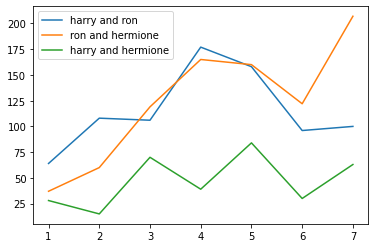

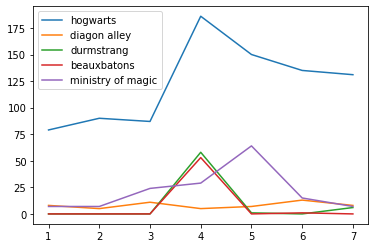

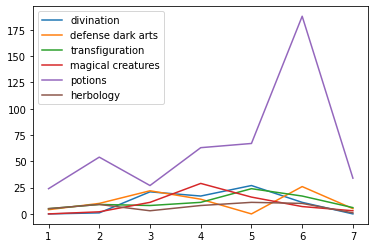

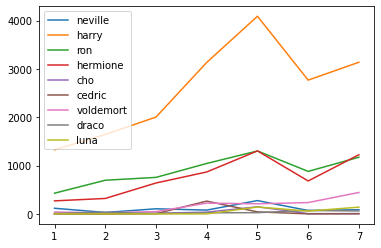

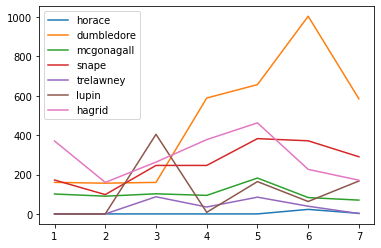

In [28]:
# relation among  main characters
query1 = find_gram(_2grams,'harry ron')
query2 = find_gram(_2grams,'ron hermione')
query3 = find_gram(_2grams,'harry hermione')

# places
query4 = find_gram(_1grams,'hogwarts')
query5 = find_gram(_2grams,'diagon alley')
query6 = find_gram(_1grams,'durmstrang')
query7 = find_gram(_1grams,'beauxbatons')
query8 =find_gram(_2grams,'ministry magic')

# lessons
query9 = find_gram(_1grams,'divination')
query10 = find_gram(_3grams,'defense dark art')
query11 = find_gram(_1grams,'transfiguration')
query12 = find_gram(_2grams,'magical creature')
query13 = find_gram(_1grams,'potion')
query14 = find_gram(_1grams,'herbology')

# characters
query15 = find_gram(_1grams,'neville')
query16 = find_gram(_1grams,'harry')
query17 = find_gram(_1grams,'ron')
query18 = find_gram(_1grams,'hermione')
query19 = find_gram(_1grams,'cho')
query20 = find_gram(_1grams,'cedric')
query21 = find_gram(_1grams,'voldemort')
query22 = find_gram(_1grams,'draco')
query23 = find_gram(_1grams,'luna')

# professors

query24 = find_gram(_1grams,'horace')
query25 = find_gram(_1grams,'dumbledore')
query26 = find_gram(_1grams,'mcgonagall')
query27 = find_gram(_1grams,'snape')
query28 = find_gram(_1grams,'trelawney')
query29 = find_gram(_1grams,'lupin')
query30 = find_gram(_1grams,'hagrid')

fig, ax = plt.subplots()
df = pd.DataFrame({'harry and ron':query1,
                   'ron and hermione':query2,
                   'harry and hermione':query3,
                   })
df.plot( ax=ax)

fig2, ax2 = plt.subplots()
df2 = pd.DataFrame({'hogwarts':query4,
                    'diagon alley':query5,
                    'durmstrang':query6,
                    'beauxbatons':query7,
                    'ministry of magic':query8
                    })
df2.plot( ax=ax2)

fig3, ax3 = plt.subplots()
df3 = pd.DataFrame({'divination':query9,
                    'defense dark arts':query10,
                    'transfiguration':query11,
                    'magical creatures':query12,
                    'potions':query13,
                    'herbology':query14})
df3.plot( ax=ax3)

fig4, ax4 = plt.subplots()
df4 = pd.DataFrame({'neville':query15,
                    'harry':query16,
                    'ron':query17,
                    'hermione':query18,
                    'cho':query19,
                    'cedric':query20,
                    'voldemort':query21,
                    'draco':query22,
                    'luna':query23})
df4.plot( ax=ax4)

fig5, ax5 = plt.subplots()
df5 = pd.DataFrame({'horace':query24,
                    'dumbledore':query25,
                    'mcgonagall':query26,
                    'snape':query27,
                    'trelawney':query28,
                    'lupin':query29,
                    'hagrid':query30
                    })
df5.plot( ax=ax5)

In [29]:
class NgramModel(object):

  def __init__(self, n):
    self.n = n

    # dictionary that keeps list of candidate words given context
    self.context = {}

    # keeps track of how many times ngram has appeared in the text before
    self.ngram_counter = {}

  def tokenize(self,text):
    """
    :param text: Takes input sentence
    :return: tokenized sentence
    """
    return text.split()

  def get_ngrams(self,n, tokens):
    """
    :param n: n-gram size
    :param tokens: tokenized sentence
    :return: list of ngrams
    ngrams of tuple form: ((previous wordS!), target word)
    """
    # tokens.append('<END>')
    tokens = (n-1)*['<START>']+tokens
    l = [(tuple([tokens[i-p-1] for p in reversed(range(n-1))]), tokens[i]) for i in range(n-1, len(tokens))]
    return l

  def update(self, sentence):
      """
      Updates Language Model
      :param sentence: input text
      """
      n = self.n
      ngrams = self.get_ngrams(n, self.tokenize(sentence))
      for ngram in ngrams:
          if ngram in self.ngram_counter:
              self.ngram_counter[ngram] += 1.0
          else:
              self.ngram_counter[ngram] = 1.0

          prev_words, target_word = ngram
          if prev_words in self.context:
              self.context[prev_words].append(target_word)
          else:
              self.context[prev_words] = [target_word]

  def prob(self, context, token):
      """
      Calculates probability of a candidate token to be generated given a context
      :return: conditional probability
      """
      try:
          count_of_token = self.ngram_counter[(context, token)]
          count_of_context = float(len(self.context[context]))
          result = count_of_token / count_of_context

      except KeyError:
          result = 0.0
      return result

  def random_token(self, context):
      """
      Given a context we "semi-randomly" select the next word to append in a sequence
      :param context:
      :return:
      """
      r = random.random()
      map_to_probs = {}
      token_of_interest = self.context[context]
      for token in token_of_interest:
          map_to_probs[token] = self.prob(context, token)

      summ = 0
      for token in sorted(map_to_probs):
          summ += map_to_probs[token]
          if summ > r:
              return token

  def generate_text(self, token_count):
      """
      :param token_count: number of words to be produced
      :return: generated text
      """
      n = self.n
      context_queue = (n - 1) * ['<START>']
      result = []
      for _ in range(token_count):
          obj = self.random_token(tuple(context_queue))
          result.append(obj)
          if n > 1:
              context_queue.pop(0)
              if obj == '.':
                  context_queue = (n - 1) * ['<START>']
              else:
                  context_queue.append(obj)
      return ' '.join(result)


def create_ngram_model(n, text):
    m = NgramModel(n)
    #text = text.split('.')
    for sentence in text:
      # add back the fullstop
      sentence += '.'
      m.update(sentence)
    return m

start = time.time()
text = all_books['preprocessed_text'].to_list()
m = create_ngram_model(6, text)

print(f'Language Model creating time: {time.time() - start}')
start = time.time()
random.seed(7)
print(f'{"="*50}\nGenerated text:')
m.generate_text(500)

Language Model creating time: 3.11788010597229
Generated text:


'harry dumbledore approached back door burrow surrounded familiar litter old wellington boot rusty cauldron harry could hear soft clucking sleepy chicken coming distant shed dumbledore knocked three time harry saw sudden movement behind kitchen window said nervous voice recognized weasley declare dumbledore bringing harry door opened stood weasley short plump wearing old green dressing gown harry dear gracious albus gave fright said expect morning lucky said dumbledore ushering harry threshold slughorn proved much persuadable expected harry course ah hello nymphadora harry looked around saw weasley alone despite lateness hour young witch pale heart shaped face mousy brown hair sitting table clutching large mug hand hello professor said wotcher harry hi tonks harry thought looked drawn even ill something forced smile certainly appearance le colorful usual without customary shade bubble gum pink hair better said quickly standing pulling cloak around shoulder thanks tea sympathy molly ple

## Vocabulary

In [30]:
def build_vocabulary(df):
  """
  Return idx_to_word, word_to_idx, word_list
  OrderedDict preserves the order in which the keys are inserted. 
  A regular dict doesn’t track the insertion order, and iterating it gives the values in an arbitrary order. 
  By contrast, the order the items are inserted is remembered by OrderedDict.
  """
  idx_to_word = OrderedDict()
  word_to_idx = OrderedDict()
  word_list=[]
  i=0
  if 'preprocessed_text' in df.columns:
    for index,row in df.iterrows():
      _word_list = row['preprocessed_text'].split()
      for w in _word_list:
        if w not in word_list:
          word_list.append(w)
          word_to_idx[w] = i
          idx_to_word[i] = w
          i+= 1
  else:
    word_list = df.index.to_list()
    for j,w in enumerate(word_list):
      idx_to_word[j]=w
      word_to_idx[w]=j
  return idx_to_word,word_to_idx,word_list

def word_frequency(df,word_to_idx):
  """
  Helper function to create the term/document matrix
  """
  data = []
  for index,row in df.iterrows():
    _data = [0]*len(word_to_idx)
    book, chapter = index
    tokens = df.loc[(book, chapter),:]['preprocessed_text'].split()
    for t in tokens:
      _data[word_to_idx[t]] += 1
    data.append(_data)
  term_doc = pd.DataFrame(data,columns=word_list,index=df.index)
  term_doc = term_doc.T
  return term_doc

## Term-doc matrix

In [31]:
idx_to_word,word_to_idx,word_list = build_vocabulary(all_books)
print(len(word_list))

19977


In [32]:
term_doc = word_frequency(all_books,word_to_idx)

In [33]:
term_doc

Book          1                               ...  7                            
Chapter      1  2  3  4   5   6  7  8  9  10  ... 28 29 30 31 32  33 34 35 36 37
boy          10  7  2  5  15  34  5  1  7  1  ...  5  0  4  2  6  24  4  6  9  1
lived         2  3  0  2   0   0  0  1  0  0  ...  0  0  0  2  1   1  2  0  2  0
dursley      47  3  0  6   0   0  0  0  0  0  ...  0  0  0  0  0   0  0  0  0  0
number        8  1  1  0   1   4  0  0  1  0  ...  0  0  0  2  0   0  1  0  1  1
four          6  2  5  0   2   4  6  0  1  2  ...  0  0  0  2  2   1  2  0  1  2
...          .. .. .. ..  ..  .. .. .. .. ..  ... .. .. .. .. ..  .. .. .. .. ..
nevillec      0  0  0  0   0   0  0  0  0  0  ...  0  0  0  0  0   0  0  0  0  1
sincere       0  0  0  0   0   0  0  0  0  0  ...  0  0  0  0  0   0  0  0  0  1
sayc          0  0  0  0   0   0  0  0  0  0  ...  0  0  0  0  0   0  0  0  0  1
cthen         0  0  0  0   0   0  0  0  0  0  ...  0  0  0  0  0   0  0  0  0  1
bereavement   0  0  0  0   0   0  0  0  0  0  ...  0  0  0  0  0   0  0  0  0  1

[19977 rows x 200 columns]

In [34]:
# select features that appear more than 5 times

term_doc = term_doc[term_doc.sum(axis=1) > 5]

In [35]:
print(f'new vocabulary length : {term_doc.shape[0]}')

idx_to_word,word_to_idx,word_list = build_vocabulary(term_doc)

new vocabulary length : 7341


## TF-IDF

TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general

In [36]:
def tf_idf(df):
  """
  matrix : shape (terms,documents)
  """
  matrix = df.to_numpy()
  N = matrix.shape[1]
  tfidf = np.zeros(matrix.shape)
  for i,wv in enumerate(matrix):
    doc = np.count_nonzero(wv)
    for j,freq in enumerate(wv):
      if freq > 0:
        tfidf[i][j] = (1 + np.log10(freq))*np.log2(N /doc)
  df = pd.DataFrame(data = tfidf, index = df.index, columns = df.columns)
  return df

def select_features(df,threshold):
  """
  sort words according to their tf-idf value
  and build a new vocab based on these new features
  """
  vocab = set()
  result = OrderedDict()
  books = df.columns.levels[0]
  for book in books:
    chapters = df[book].columns
    ch_features = {}
    for chapter in chapters:
      # select for each chapters words that have a tf-idf value greater than a fixed threshold
      selected_features = df.loc[:,(book,chapter)][df.loc[:,(book,chapter)] > threshold].sort_values(ascending=False)
      ch_features[chapter] = selected_features
      vocab.update(selected_features)
    result[book] = ch_features
  return vocab,result

def print_feature(features,show=10):
  """
  print the most relevant features per document
  """
  for book,value in features.items():
    for key,f in value.items():
      print(f'Book_{book} Chapter_{key} : ')
      print(f[:show],'\n')

def jaccard(query,features,deep=False):
  """
  compute the jaccard distance between a query and a document
  """
  res = OrderedDict()
  w_query = query.split()
  if deep:
    for (book,chapter) in features.index:
      name = 'book_{} chapter_{}'.format(book,chapter)
      f = features.loc[(book,chapter),'tokenized']
      res[name] = 1 - _jaccard_coefficient(w_query,f)

  else:
    for book,value in features.items():
      for chapter,f in value.items():
        name = 'book_{} chapter_{}'.format(book,chapter)
        res[name] = 1 - _jaccard_coefficient(w_query,f.index)
  return print(sorted(res.items(),key=lambda x:x[1]))

def _jaccard_coefficient(list1, list2):
  """
  compute jaccard coefficient
  """
  intersection = len(list(set(list1).intersection(list2)))
  union = (len(list1) + len(list2)) - intersection
  return intersection / union

def cosine(df,word,dim=None,ascending=False,threshold=0.5,sorted_column='cosine',text=False,show=10):

  matrix = df.to_numpy() if dim is None else df.to_numpy()[:,dim[0]:dim[1]+1]

  if type(word) == np.ndarray:
    word = word if dim is None else word[dim[0]:dim[1]+1]
  else:
    word = df.loc[word].to_numpy() if dim is None else df.loc[word].to_numpy()[:dim[0],:dim[1]+1,None] # column vector 

  matrix_norm = np.linalg.norm(matrix,axis = 1)
  word_norm = np.linalg.norm(word)

  result = matrix @ word
  norm = matrix_norm * word_norm
  norm = np.where(norm == 0, 1, norm) # we cannot divide by 0

  if text:
    result = {'cosine':result/norm, 'norm':matrix_norm,'text':all_books['Text']}
    cosine_similarity = pd.DataFrame(result,index=df.index,columns=['cosine','norm','text']).sort_values(ascending=ascending,by=sorted_column)

  else:
    result = {'cosine':result/norm, 'norm':matrix_norm}
    cosine_similarity = pd.DataFrame(result,index=df.index,columns=['cosine','norm']).sort_values(ascending=ascending,by=sorted_column)

  cosine_similarity = cosine_similarity[cosine_similarity[sorted_column] > threshold].head(show)
  return cosine_similarity


In [37]:
tfidf = tf_idf(term_doc)

In [38]:
tfidf

Book             1                      ...         7                    
Chapter         1         2         3   ...        35        36        37
boy       0.418456  0.386046  0.272212  ...  0.372039  0.408882  0.209228
lived     2.323477  2.637954  0.000000  ...  0.000000  2.323477  0.000000
dursley   9.985538  5.519951  0.000000  ...  0.000000  0.000000  0.000000
number    1.591937  0.836501  0.836501  ...  0.000000  0.836501  0.836501
four      0.951901  0.696483  0.909513  ...  0.000000  0.535332  0.696483
...            ...       ...       ...  ...       ...       ...       ...
listener  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
scabior   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
diadem    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
bogrod    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
tuney     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000

[7341 rows x 200 columns]

In [39]:
new_vocab,tfidf_features = select_features(tfidf,threshold=4)
print(len(new_vocab))

875


In [40]:
print_feature(tfidf_features)

Book_1 Chapter_1 : 
drill          10.773629
dursley         9.985538
motorcycle      9.041796
lemon           8.594909
celebrating     7.748365
outer           6.859539
bundle          6.703699
careless        6.292433
earmuff         6.058894
daylight        5.986843
Name: (1, 1), dtype: float64
Book_1 Chapter_2 : 
pier           11.930792
zoo            10.035630
motorcycle      9.041796
brazil          8.949721
computer        8.526048
constrictor     8.336660
boa             8.336660
figg            7.601075
frying          7.342826
trash           6.923988
Name: (1, 2), dtype: float64
Book_1 Chapter_3 : 
smelting      14.103664
doormat        8.336660
smeltings      8.336660
spray          7.882802
pier           7.342826
uniform        6.923988
computer       6.923988
marge          6.859539
television     6.723272
figg           6.608539
Name: (1, 3), dtype: float64
Book_1 Chapter_4 : 
ry          9.041796
knowin      7.882802
mom         7.472599
gettin      7.342826
somethin 

In [41]:
# I could match the query against the whole raw chapter instead of only tf-idf features
query = "motorcycle hagrid street"
jaccard(query,tfidf_features)

query2 = "hogwarts"
jaccard(query2,tfidf_features)

query3 = "tom riddle slytherin chamber secret hogwarts"
jaccard(query3,tfidf_features)

[('book_1 chapter_1', 0.9803921568627451), ('book_1 chapter_2', 0.989010989010989), ('book_7 chapter_28', 0.9913793103448276), ('book_7 chapter_4', 0.9939024390243902), ('book_7 chapter_10', 0.9944444444444445), ('book_5 chapter_7', 0.9947643979057592), ('book_1 chapter_3', 1.0), ('book_1 chapter_4', 1.0), ('book_1 chapter_5', 1.0), ('book_1 chapter_6', 1.0), ('book_1 chapter_7', 1.0), ('book_1 chapter_8', 1.0), ('book_1 chapter_9', 1.0), ('book_1 chapter_10', 1.0), ('book_1 chapter_11', 1.0), ('book_1 chapter_12', 1.0), ('book_1 chapter_13', 1.0), ('book_1 chapter_14', 1.0), ('book_1 chapter_15', 1.0), ('book_1 chapter_16', 1.0), ('book_1 chapter_17', 1.0), ('book_2 chapter_1', 1.0), ('book_2 chapter_2', 1.0), ('book_2 chapter_3', 1.0), ('book_2 chapter_4', 1.0), ('book_2 chapter_5', 1.0), ('book_2 chapter_6', 1.0), ('book_2 chapter_7', 1.0), ('book_2 chapter_8', 1.0), ('book_2 chapter_9', 1.0), ('book_2 chapter_10', 1.0), ('book_2 chapter_11', 1.0), ('book_2 chapter_12', 1.0), ('book

the cosine between 2 chapters of the same book should be higher

Hence, the cosine between two different books, should be lower, and even lower between two books that are far from each others in the serie

In [42]:
# cosine between book_1 chapter_10 and book_1 chapter_11
# cosine between book_1 chapter_10 and book_7 chapter_35
print(cosine(tfidf.T,tfidf.T.loc[1,10].to_numpy(),threshold=0).loc[1,11],'\n')
print(cosine(tfidf.T,tfidf.T.loc[1,10].to_numpy(),threshold=0,show=200).loc[7,35])

cosine     0.211843
norm      70.369302
Name: (1, 11), dtype: float64 

cosine     0.070537
norm      83.456035
Name: (7, 35), dtype: float64


In [43]:
cosine(tfidf,'ron')

cosine      norm
ron       1.000000  4.698181
hermione  0.978394  5.771179
get       0.954231  0.578502
got       0.950664  0.600594
look      0.942581  0.190320
said      0.942557  0.286160
think     0.940546  0.194249
going     0.939851  0.928143
come      0.938050  0.549789
looking   0.938029  0.580198

In [44]:
cosine(tfidf,'eater')

cosine       norm
eater      1.000000  19.540346
death      0.868455  11.859084
voldemort  0.717924  12.644506
body       0.686913  10.304185
upon       0.684090  10.234432
curse      0.678512  13.188657
spell      0.646298  10.938720
order      0.644623  10.397738
place      0.641647   3.527385
saw        0.640569   0.700433

In [45]:
cosine(tfidf,'hogwarts',show=30)

cosine      norm
hogwarts  1.000000  4.935883
year      0.901170  1.704060
would     0.900086  0.204137
know      0.899935  0.211789
well      0.899779  1.177023
time      0.899419  0.198706
say       0.898220  1.377916
never     0.898018  0.872843
said      0.896054  0.286160
long      0.894490  0.858376
got       0.892285  0.600594
way       0.891700  0.175654
go        0.891199  0.184873
thought   0.889690  0.365154
think     0.889249  0.194249
looking   0.888985  0.580198
see       0.888182  0.198172
look      0.887587  0.190320
right     0.886954  0.190874
last      0.886444  0.684609
face      0.886233  0.192593
asked     0.885483  2.051605
get       0.884731  0.578502
school    0.884477  5.605922
take      0.883627  1.105684
might     0.883254  0.963027
voice     0.882854  0.187164
come      0.882852  0.549789
left      0.882706  1.160355
door      0.882676  2.038832

### Conclusion

there are others methods to extract features :
* PPMI (positive pointwise mutual information)
* Chi square
* Naives bayes

But these methods produce sparse matrices. Besides they do not capture any semantic properties at all.

We will investigate methods that that can leverage these problems.


## LSA

Transform the terms-docs matrix by bringing out latent
semantic associations between terms and documents
* It maps the matrix in a new vector space with lower dimensions which
approximates the original space ignoring the “noise”, namely
irrelevant details
* latent semantic associations are superior order associations based on
lower lexical match among terms
* in the transformed space, terms semantically similar or
associated are placed in neighboring positions
* The semantic similarity among terms lexically different emerges
thanks to the co-occurences of terms in distinct docs
* Latent Semantic Indexing: the transformed space is used in
information retrieval as the index for similarity searches

In [46]:
def plot_graph(df,dim=(0,1),mode='words',size=(30,20),c_color='black',query=None):
  if mode != 'all': _df = df
  fig, ax = plt.subplots(figsize=size)
  if mode == 'words' or mode == 'all':
    if mode == 'all': _df = df[0]
    ax.scatter(x=_df.loc[:,dim[0]],y=_df.loc[:,dim[1]],s=3)
    for w in _df.index:
      ax.annotate(w, (_df.loc[w,dim[0]], _df.loc[w,dim[1]]))
  if mode == 'books' or mode == 'all':
    if mode == 'all': _df = df[1]
    color = {1:'blue',2:'orange',3:'green',4:'purple',5:'red',6:'yellow',7:'brown'}
    for book in color:
      label = 'book_{}'.format(book)
      ax.scatter(_df.loc[(book,),dim[0]],_df.loc[(book,),dim[1]],c=color[book],s=90,alpha=0.4,label=label)
    if query!=None:
      text = query[1]
      q = query[0]
      q = q / np.linalg.norm(q)  # we normalize the query
      ax.scatter(q[dim[0]],q[dim[1]],c='#7d5fff',marker='>',label=text,s=300) 
    ax.scatter(x=0,y=0,label='center',c='#4cd137',s=450,marker='h')
    ax.legend(loc='upper right')


In [47]:
matrix = tfidf.to_numpy()
u,sigma,vt = np.linalg.svd(matrix,full_matrices=False)

u.shape,sigma.shape,vt.shape
# u (words,topic)    s (topic,topic)    vt (topic,doc)

((7341, 200), (200,), (200, 200))

(-1.0, 200.0, 0.0, 150.0)

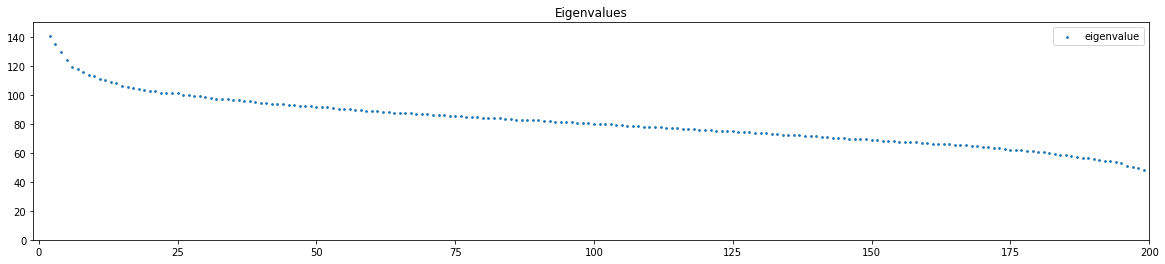

In [48]:
# plot eigenvalues

plt.figure(figsize=(20,4))
plt.scatter(x=np.arange(0,200,1),y=sigma.tolist(),s=3,label='eigenvalue')
plt.title('Eigenvalues')
plt.legend(loc='upper right')
plt.axis([-1,200,0,150])

$\sqrt{\lambda}$ is the data variability for each dimension

In [49]:
# we have to weight words and docs in the LSA space
# @ is the python symbol to perform a matrix product (* is the operator for element wise multiplication)
# we could also use np.matmul(u,np.diag(sigma))

lsa_words = u @ np.diag(sigma)
lsa_docs = vt @ np.diag(sigma) # (topics,docs)
lsa_docs = lsa_docs.T  # (docs,topics)

In [50]:
# we put lsa_words and lsa_docs into dataframes

# lsa_docs (docs,topics)
lsa_docs = pd.DataFrame(data=lsa_docs,index=books_chapters,columns=[i for i in range(200)])

# lsa_words (words,topics)
lsa_words = pd.DataFrame(lsa_words,index=tfidf.index,columns=[i for i in range(200)])

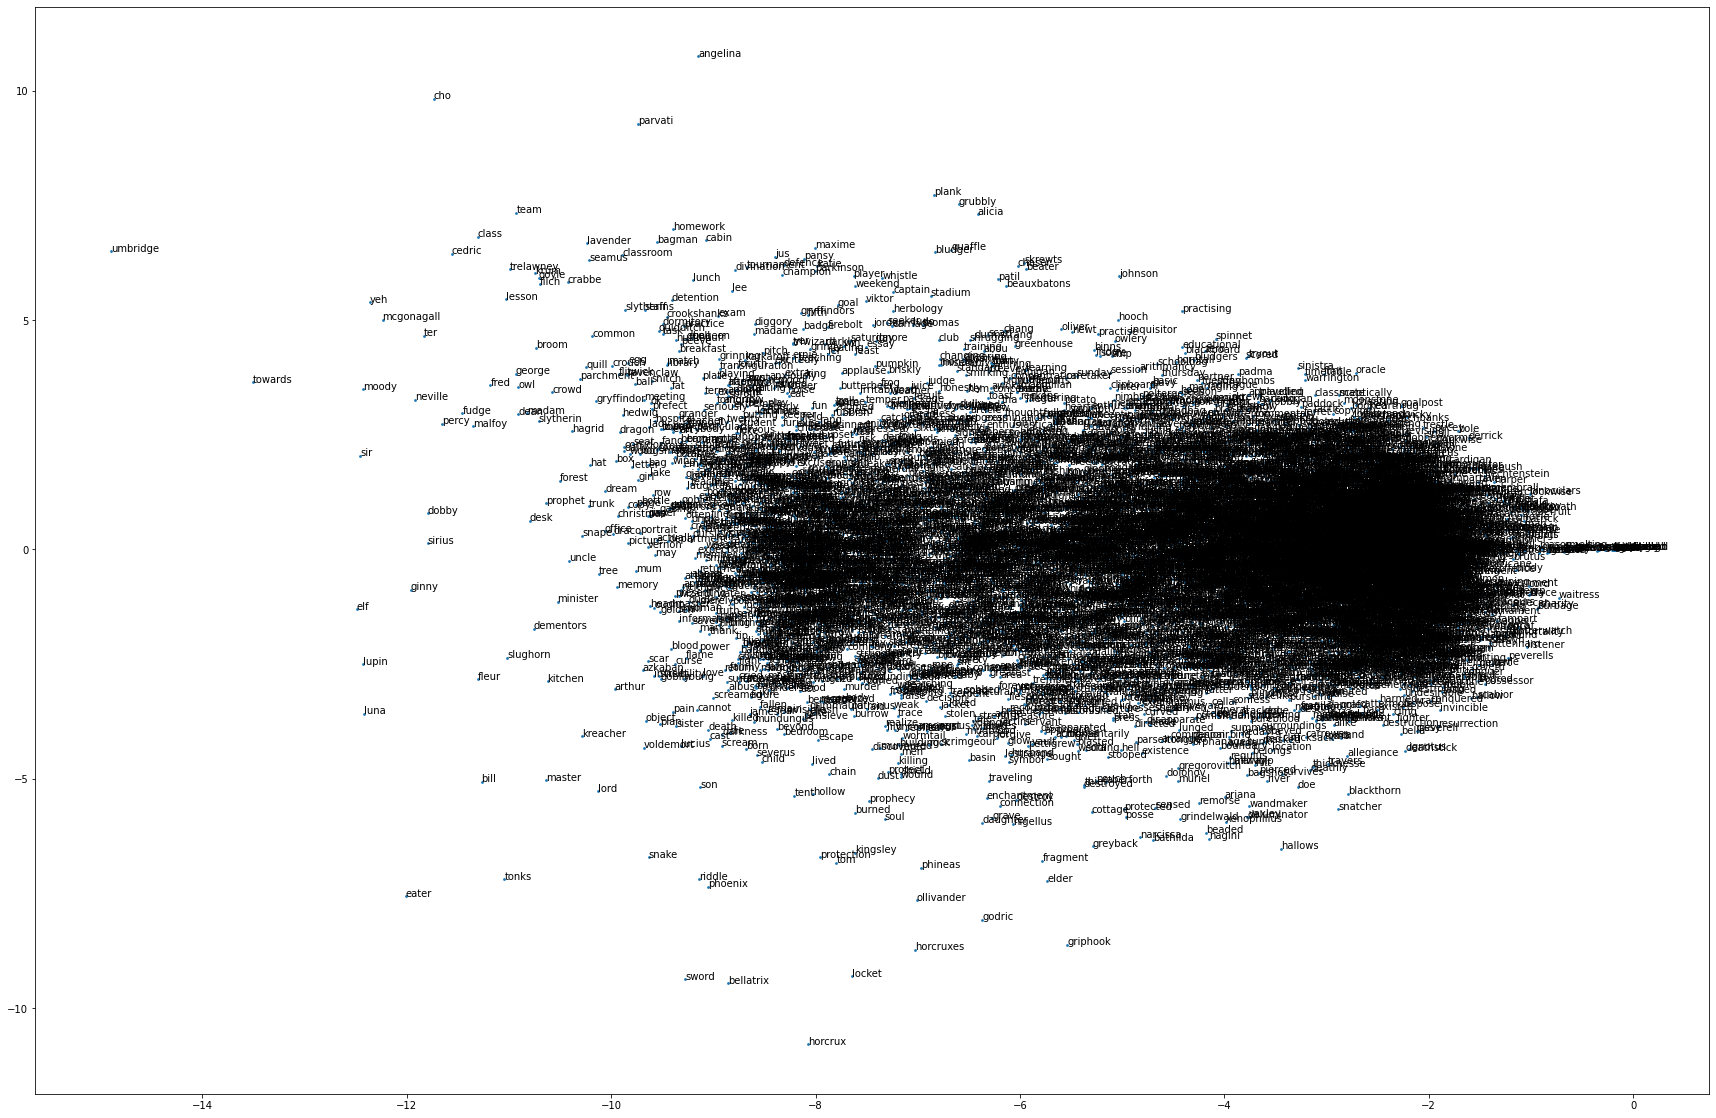

In [51]:
# plot words in the 1st and 2nd dimension of the LSA space
plot_graph(lsa_words)

Words are all packed, we cannot use the 1st and 2nd dimension to plot because the first one is prevalent over the second.  
The first dimension is too much weighted compared to others.


In [52]:
print(f' first eigenvalue : {sigma[0]}   -     second eigenvalue : {sigma[1]}')

 first eigenvalue : 448.20185667125173   -     second eigenvalue : 156.52202010972158


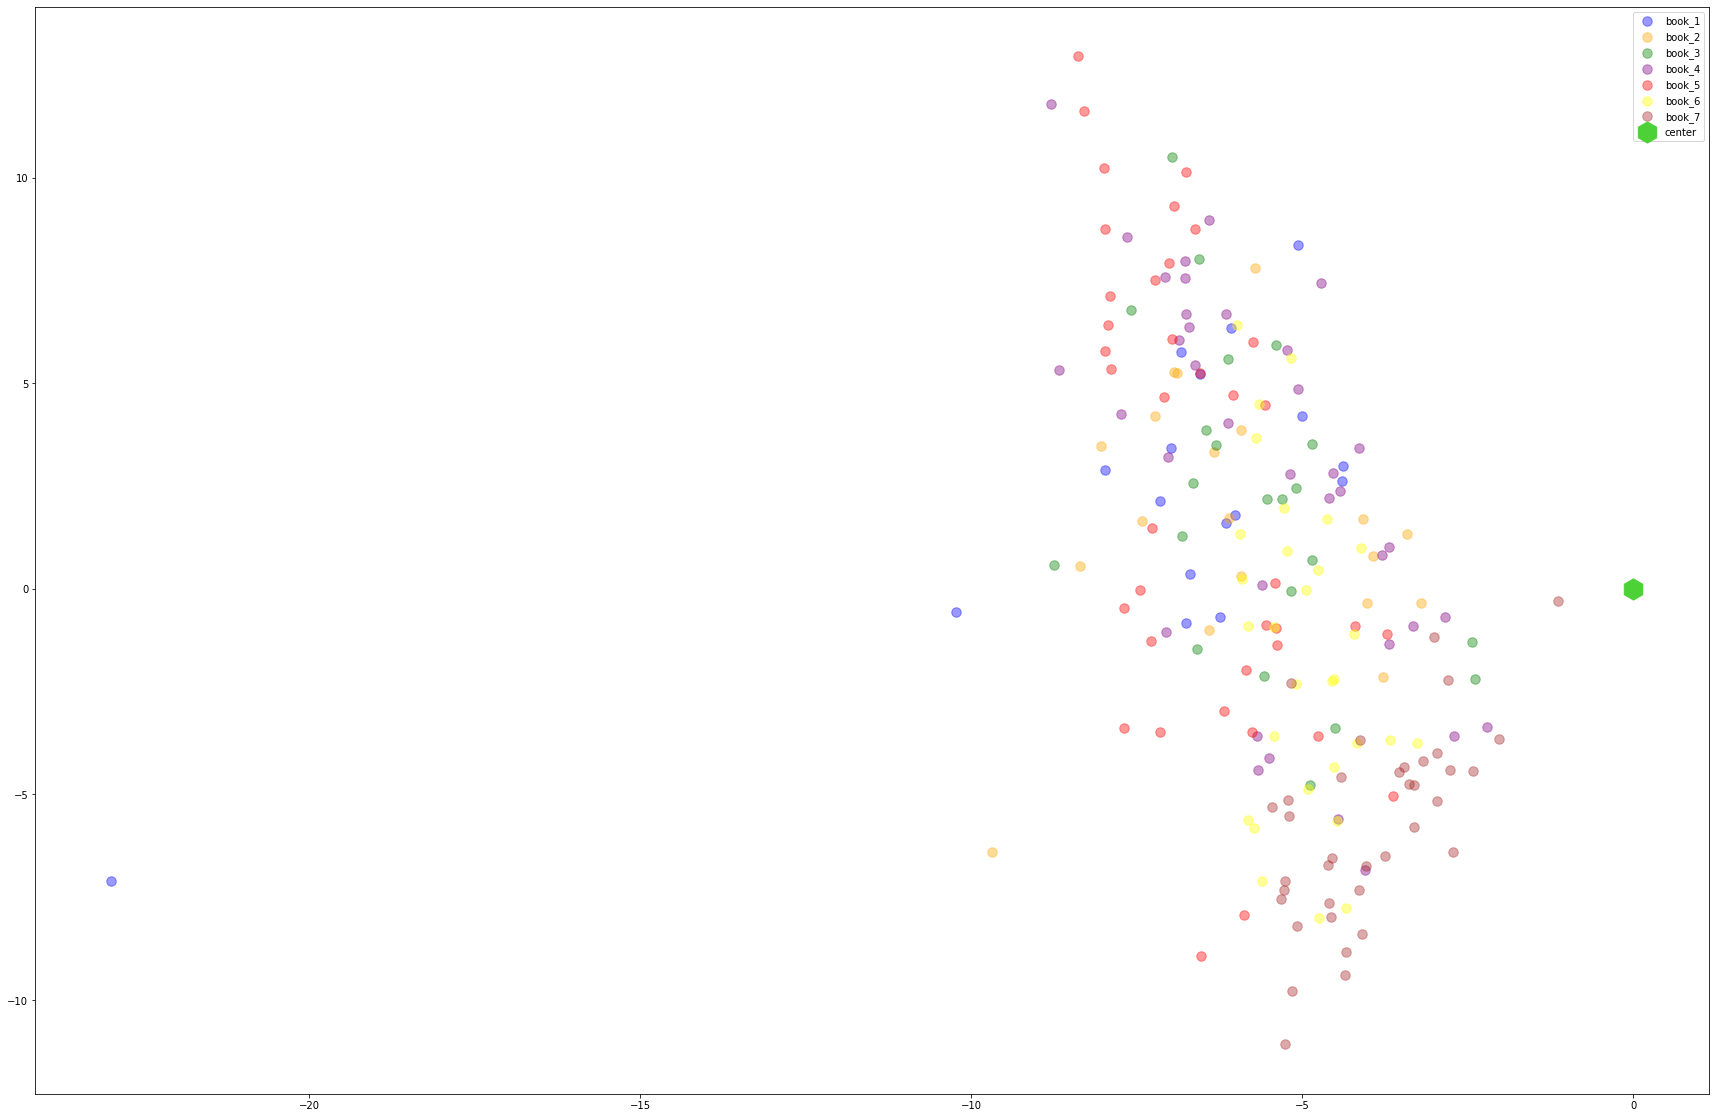

In [53]:
# plot books in the 1st and 2nd dimension of the LSA space
plot_graph(lsa_docs,mode='books')

We need to normalize documents and words

In [54]:
# compute norm 

word_norm = np.linalg.norm(lsa_words,ord=2,axis=1)
doc_norm = np.linalg.norm(lsa_docs,ord=2,axis=1)

We have 200 documents but more than 7 000 words. That is a bit too much, we will only consider words with highest norm

In [55]:
# select only words with norm > 18
norm_threshold = 18

lsa_words_reduced = lsa_words[word_norm > norm_threshold]
print(f" we will consider {lsa_words_reduced.shape[0]} words")

 we will consider 402 words


In [56]:
# normalization

lsa_words_reduced_normalized = lsa_words_reduced.div(word_norm[word_norm > norm_threshold],axis=0)
lsa_docs_normalized = lsa_docs.div(doc_norm,axis=0)

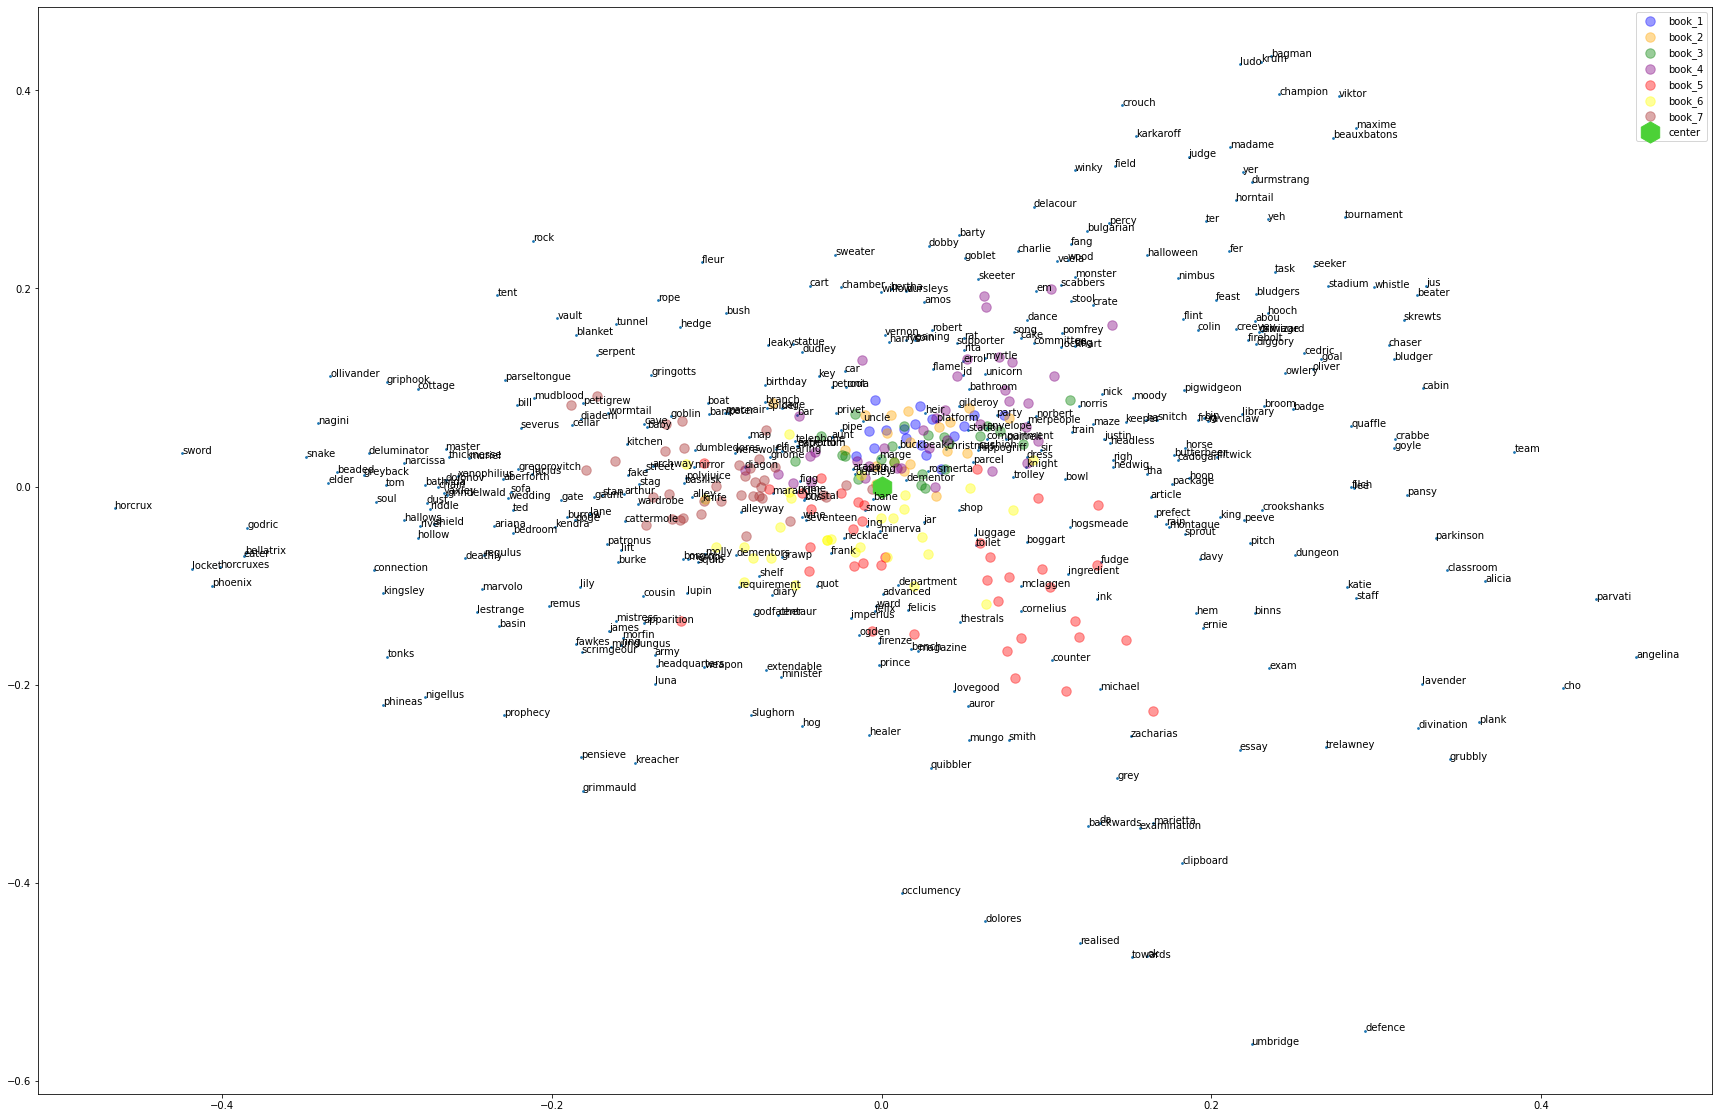

In [57]:
plot_graph(df=[lsa_words_reduced_normalized,lsa_docs_normalized],mode='all',dim=(1,2))

We want to know if the word `umbridge` is related to the book 5

---



In [58]:
def is_related(word,book,alpha=0.05,verbose=True):
  """
  chi-square test between a word and a book
  """
  docs = 200
  docs_with_book = len(all_books.loc[book,:].index)
  docs_with_word = term_doc.loc[word,:][(term_doc.loc[word,:] > 0)]
  dww = docs_with_word.shape[0]
  if book in docs_with_word.index.unique(level='Book'):
    docs_with_word_with_book = docs_with_word.loc[book,:].shape[0]
  else:
    docs_with_word_with_book = 0

  yw_yb = docs_with_word_with_book
  yw_nb = dww - yw_yb
  nw_yb = docs_with_book - yw_yb
  nw_nb = docs - dww
  observed = np.array([yw_yb,yw_nb,nw_yb,nw_nb]).reshape((2,2))
  chi2,p,dof,expected = chi2_contingency(observed)
  if verbose:
    print(f'p-value is : {p} degree of freedom : {dof}')
  if p < alpha:
    print(f'{word} is correlated to book_{book} - STATUS : dependent')
  else:
    print(f'{word} is not correlated to book_{book} - STATUS : independent')
  if verbose:
    print('observed : ')
    print(observed)
    print('expected : ')
    print(expected)

In [59]:
for book in books:
  is_related('umbridge',book,verbose=False)

umbridge is not correlated to book_1 - STATUS : independent
umbridge is not correlated to book_2 - STATUS : independent
umbridge is correlated to book_3 - STATUS : dependent
umbridge is correlated to book_4 - STATUS : dependent
umbridge is correlated to book_5 - STATUS : dependent
umbridge is not correlated to book_6 - STATUS : independent
umbridge is not correlated to book_7 - STATUS : independent


Umbridge is not in the book 3 nor 4. It is maybe because she works in the ministerium of magic and these books are highly correlated with it.

In [60]:
cosine(lsa_words_reduced,'umbridge')

cosine       norm
umbridge   1.000000  28.964892
defence    0.741455  21.135517
dolores    0.736710  18.662132
towards    0.721995  24.057765
ok         0.625986  19.806561
realised   0.615968  18.096152
backwards  0.583964  18.866198
da         0.559273  19.511514
cho        0.555906  23.781173
clipboard  0.553335  19.339300

We will add the word `defence` to the query, because it is semantically similar to `umbridge` (it doesn't have the highest norm but we can infer that this word is more meaningfull than `towards`).

Let's verify that this word is related to book 5

In [61]:
for book in books:
  is_related('defence',book,verbose=False)

defence is not correlated to book_1 - STATUS : independent
defence is not correlated to book_2 - STATUS : independent
defence is not correlated to book_3 - STATUS : independent
defence is not correlated to book_4 - STATUS : independent
defence is correlated to book_5 - STATUS : dependent
defence is not correlated to book_6 - STATUS : independent
defence is not correlated to book_7 - STATUS : independent


In [63]:
def make_query(*args,dim=None,text=False,threshold=0.5,ascending=False,sorted_column='cosine'):
  """
  we query docs that contains similarities with args
  we turn the query into a doc
  """
  def _tfidf(s):
    N = term_doc.shape[1]
    for w,value in s.iteritems():
      if value!=0:
        docs = term_doc.loc[w,:][term_doc.loc[w,:] > 0].shape[0]
        s[w] = (1 + np.log10(value))*np.log2(N / docs)
    return s

  query = np.zeros((u.shape[0],1))

  for w in args:
    query[word_to_idx[w]] = 1
  query = pd.Series(query.reshape(-1),index=term_doc.index)
  query = _tfidf(query)

  lsa_query = np.linalg.inv(np.diag(sigma))  @ u.T @ query
  lsa_query = lsa_query @ np.diag(sigma)  # we have to weight the new doc with the eigenvalues

  similarities = cosine(lsa_docs,lsa_query,dim=dim,text=text,threshold=threshold,ascending=ascending,sorted_column=sorted_column)
  return lsa_query,similarities

In [64]:
q,sim = make_query('umbridge','defence',dim=(1,2),text=True)
sim

cosine  ...                                               text
Book Chapter            ...                                                   
5    29       1.000000  ...  Careers Advice 'But why haven't you got Occlum...
6    15       0.999990  ...   Snow was swirling against the icy windows onc...
5    26       0.999464  ...  Seen and UnforseenLuna said vaguely that she d...
6    21       0.998515  ...   Harry wracked his brains over the next week a...
     9        0.995507  ...   Harry and Ron met Hermione in the common room...
5    15       0.995006  ...  The Hogwart's HighInquisitorThey had expected ...
     25       0.994313  ...  The Beetle at BayHarry's question was answered...
6    24       0.990896  ...   Exhausted but delighted with his night's work...
5    28       0.988530  ...  Snapes Worst MemoryBY ORDER OF THE MINISTRY OF...
6    12       0.981523  ...   Where was Dumbledore, and what was he doing? ...

[10 rows x 3 columns]

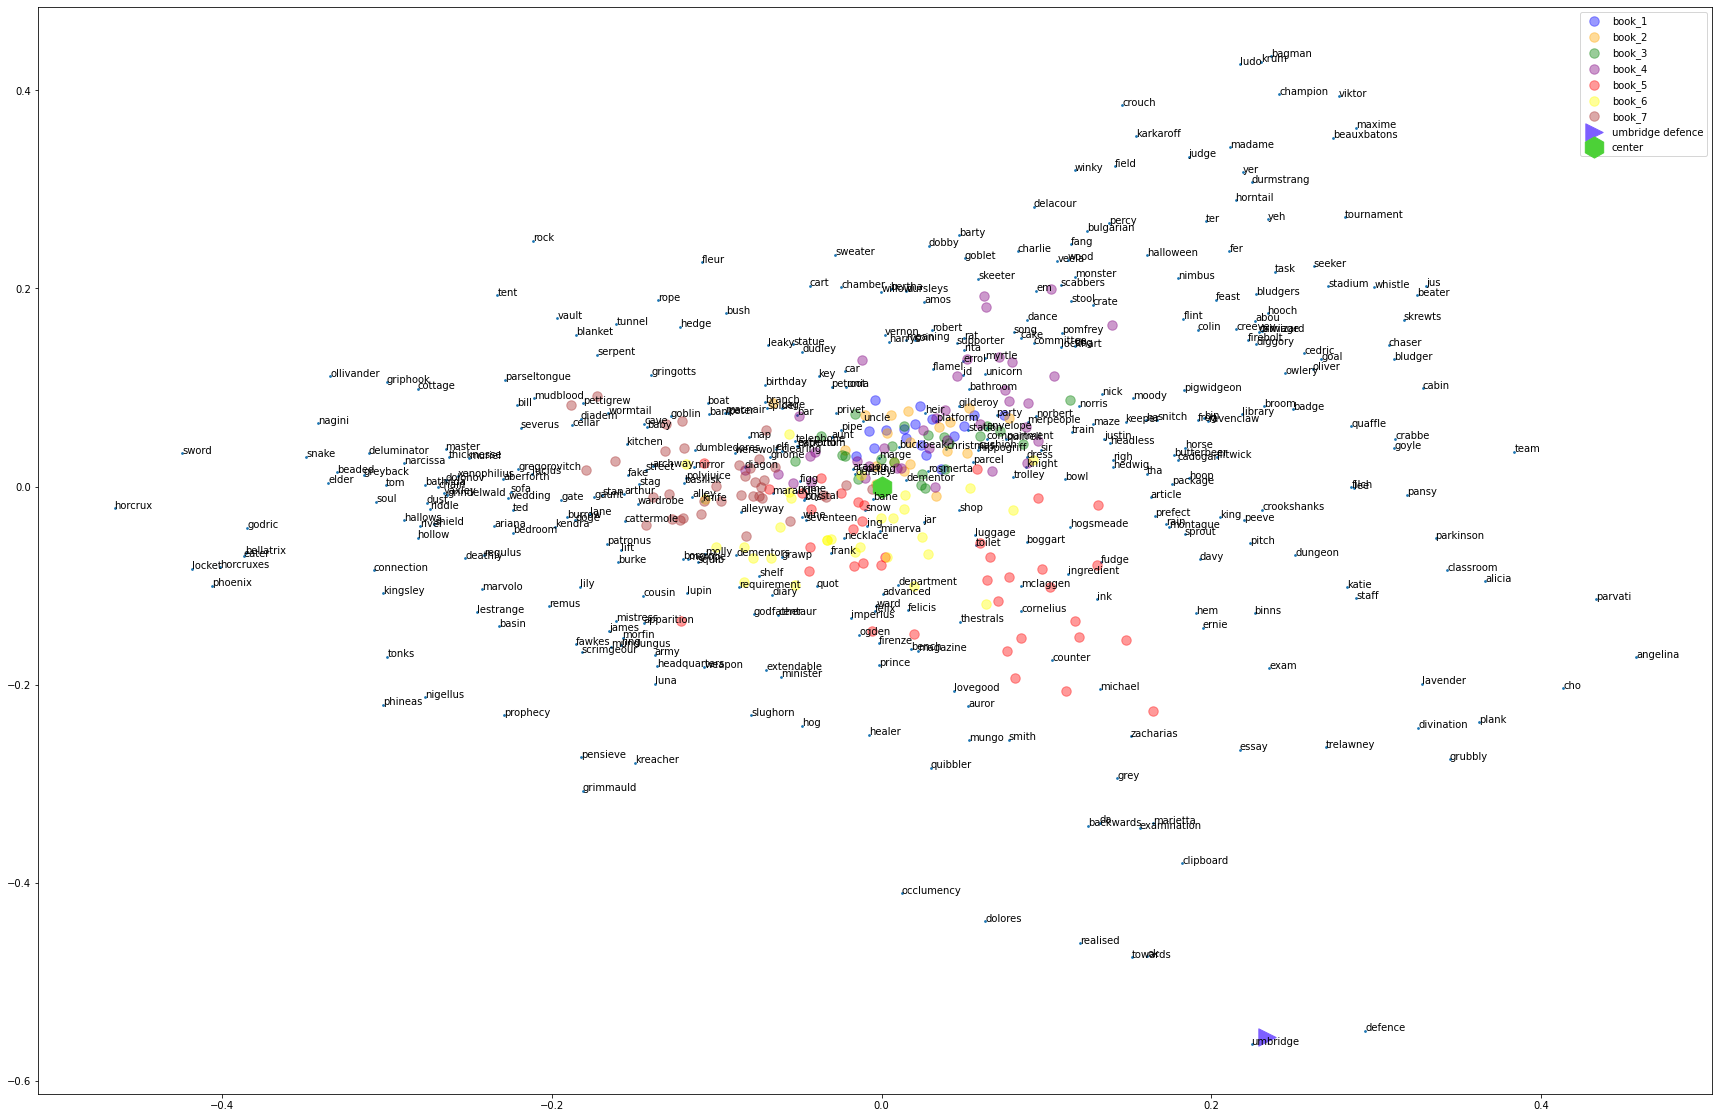

In [65]:
plot_graph(df=[lsa_words_reduced_normalized,lsa_docs_normalized],mode='all',dim=(1,2),query=[q,'umbridge defence'])

So far we worked only with dimension 1 and 2 of the LSA space.  
Now we will choose an LSA space with more size and therefore less loss of information.  
To choose the correct rank, we apply the low rank approximation method:

>*Given a matrix C, MxN, with rank r, we wish to find an MxN matrix Ck, so as to minimize the frobenius norm of the matrix difference X = C - Ck*





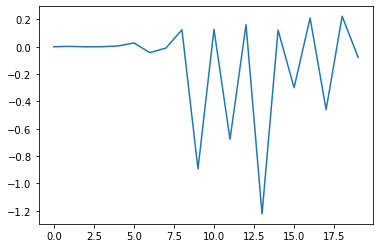

In [66]:
def diff(s):
  result = s[1:len(s)] - s[:len(s)-1]
  return result

s = diff(sigma)
sq = diff(s)
skcurv = sq[:20] / (1+s[:20]**2)**1.5
plt.plot(np.arange(0,20,1),skcurv)

the first local minimum is 8, so we select the first 8 dimensions of the LSA space

In [97]:
q,sim = make_query('umbridge','defence',dim=(1,8),text=True)
sim

cosine  ...                                               text
Book Chapter            ...                                                   
5    29       0.971517  ...  Careers Advice 'But why haven't you got Occlum...
     17       0.939057  ...  Educational DecreeNumber Twenty-fourHarry felt...
     15       0.875011  ...  The Hogwart's HighInquisitorThey had expected ...
     26       0.847031  ...  Seen and UnforseenLuna said vaguely that she d...
     12       0.805342  ...  Professor UmbridgeSeamus dressed at top speed ...
     28       0.795882  ...  Snapes Worst MemoryBY ORDER OF THE MINISTRY OF...
     27       0.791364  ...  The Centaur andThe Sneak'I'll bet you wish you...
     32       0.757526  ...  Out of the Fire'I'm not going . . . I don't ne...
     31       0.754154  ...  OWLsRon's euphoria at helping Gryffindor scrap...
     21       0.753384  ...  The Eye of the SnakeHermione ploughed her way ...

[10 rows x 3 columns]

In [98]:
cosine(lsa_words,q,dim=(1,8))

cosine       norm
umbridge     0.989082  20.084831
defence      0.985957  14.709362
recognise    0.985664   5.647966
clipboard    0.983919   9.438084
educational  0.964283   9.596721
realise      0.962051   9.427384
marietta     0.959440   8.026327
stretching   0.957580   4.280979
murtlap      0.956430   5.186016
noticeboard  0.955235   6.352106

In [99]:
q2,sim = make_query('umbridge','defence','educational',dim=(1,8))
sim

cosine       norm
Book Chapter                     
5    29       0.956412  17.278877
     17       0.951559  16.739814
     26       0.871450  18.305505
     15       0.869131  21.670991
     12       0.809596  30.060532
     28       0.801956  17.596788
     27       0.781019  17.471571
     21       0.778576  14.634621
     13       0.767177  23.641139
     16       0.757872  12.530920

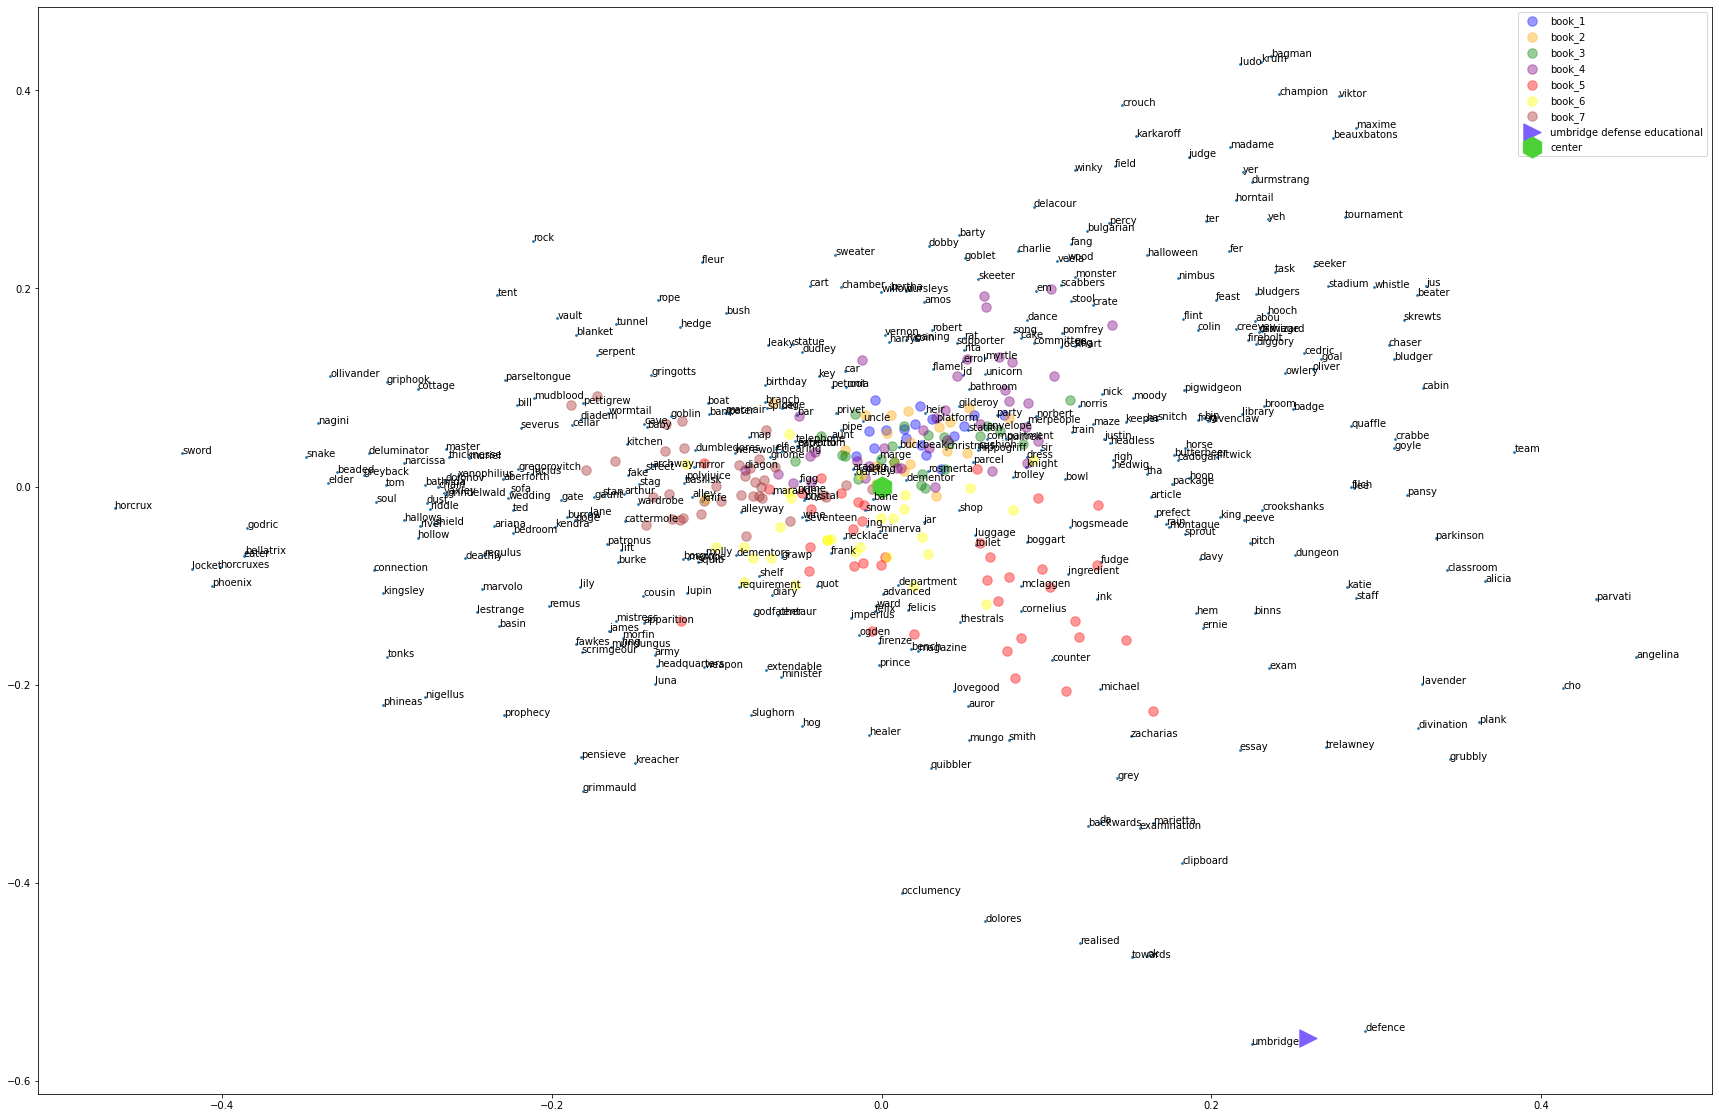

In [100]:
plot_graph(df=[lsa_words_reduced_normalized,lsa_docs_normalized],mode='all',dim=(1,2),query=[q2,'umbridge defense educational'])

There are others methods to represent words and docs (called topic modelling) than LSA:
* LDA (Latent dirichlet allocution)
* pLSA
* lda2Vec (deep learning approach)


## Word2Vec

In [71]:
def create_corpus(df):
  texts = df['Text'].apply(lambda x:preprocess_pipeline(x,remove_dot=False))
  corpora = []
  for index,row in texts.iteritems():
    text = row.split('.')
    for t in text:
      seq = t.split()
      corpora.append(seq)
  corpora = list(filter(lambda x:x!=[],corpora))
  return corpora

In [72]:
texts = create_corpus(all_books)

In [73]:
from gensim.models import Word2Vec

if os.path.exists('word2vec.model'):
  word2vec = Word2Vec.load('word2vec.model')
else:
  word2vec = Word2Vec(sentences=texts, min_count=5,workers=4,window=5)
  # summarize the loaded model
  print(word2vec)
  word2vec.train(sentences=texts,epochs=50,total_examples=word2vec.corpus_count)
  word2vec.save("word2vec.model")

Word2Vec(vocab=8432, size=100, alpha=0.025)


/usr/local/lib/python3.6/dist-packages/gensim/utils.py:589: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  if hasattr(self, attrib):
/usr/local/lib/python3.6/dist-packages/gensim/utils.py:590: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  asides[attrib] = getattr(self, attrib)
/usr/local/lib/python3.6/dist-packages/gensim/utils.py:591: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  delattr(self, attrib)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/gensim/

In [74]:
word2vec.most_similar('beauxbatons')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('durmstrang', 0.6710604429244995),
 ('madame', 0.5742539167404175),
 ('ship', 0.49715444445610046),
 ('maxime', 0.4837947189807892),
 ('milling', 0.4751800298690796),
 ('selected', 0.42265695333480835),
 ('paddock', 0.42105603218078613),
 ('delacour', 0.4204794764518738),
 ('group', 0.4179631471633911),
 ('delegation', 0.41050171852111816)]

In [75]:
word2vec.most_similar('harry')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ron', 0.6622185707092285),
 ('hermione', 0.5729013085365295),
 ('she', 0.4612293243408203),
 ('he', 0.46091848611831665),
 ('him', 0.45090100169181824),
 ('cho', 0.4403349459171295),
 ('back', 0.4380863308906555),
 ('snape', 0.43345263600349426),
 ('her', 0.4262793958187103),
 ('dobby', 0.39829370379447937)]

## Lda

In [76]:
texts = [text.split() for text in all_books['preprocessed_text'].to_list()]

In [77]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(texts)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in texts]

In [78]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2384
Number of documents: 200


In [79]:

# Set training parameters.
num_topics = 20
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [80]:
pprint(model.print_topics())
doc_lda = model[corpus]

[(0,
  '0.013*"neville" + 0.012*"lupin" + 0.011*"wood" + 0.011*"team" + '
  '0.009*"slytherin" + 0.008*"broom" + 0.007*"class" + 0.007*"mcgonagall" + '
  '0.007*"match" + 0.006*"snitch"'),
 (1,
  '0.011*"sword" + 0.009*"tent" + 0.007*"lift" + 0.007*"locket" + '
  '0.007*"horcrux" + 0.005*"golden" + 0.004*"tree" + 0.004*"invisibility" + '
  '0.003*"fudge" + 0.003*"snow"'),
 (2,
  '0.013*"mcgonagall" + 0.009*"lupin" + 0.008*"hat" + 0.007*"quirrell" + '
  '0.006*"percy" + 0.005*"mirror" + 0.005*"nick" + 0.005*"slytherin" + '
  '0.004*"feast" + 0.004*"neville"'),
 (3,
  '0.023*"slughorn" + 0.017*"riddle" + 0.010*"lord" + 0.010*"sir" + '
  '0.008*"memory" + 0.008*"tom" + 0.006*"wormtail" + 0.005*"bottle" + '
  '0.005*"soul" + 0.004*"horcruxes"'),
 (4,
  '0.026*"lupin" + 0.016*"bill" + 0.013*"tonks" + 0.010*"fleur" + '
  '0.006*"kitchen" + 0.005*"mundungus" + 0.005*"mum" + 0.004*"arthur" + '
  '0.004*"gaunt" + 0.004*"eater"'),
 (5,
  '0.014*"cedric" + 0.013*"krum" + 0.011*"moody" + 0.010*"ba

### Model evaluation

Perplexity is one of the intrinsic evaluation metric, and is widely used for language model evaluation. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.

Focussing on the log-likelihood part, you can think of the perplexity metric as measuring how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held-out data.

However, recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated.

> Optimizing for perplexity may not yield human interpretable topics

This limitation of perplexity measure served as a motivation for more work trying to model the human judgment, and thus Topic Coherence.

The concept of topic coherence combines a number of measures into a framework to evaluate the coherence between topics inferred by a model.


**What is topic coherence?**

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference

**What is coherence?**

A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

*some coherence measure*

* `C_v` measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
* `C_p` is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
* `C_uci` measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
* `C_umass` is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
* `C_npmi` is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
* `C_a` is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

In [81]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

pprint(top_topics)

Average topic coherence: -1.0558.
[([(0.013721798, 'cedric'),
   (0.013004066, 'krum'),
   (0.01093051, 'moody'),
   (0.00963414, 'bagman'),
   (0.008422491, 'crouch'),
   (0.008357899, 'champion'),
   (0.0070191273, 'rita'),
   (0.0060758935, 'task'),
   (0.006044267, 'fleur'),
   (0.0060078697, 'maxime'),
   (0.0058408873, 'madame'),
   (0.0058131255, 'skeeter'),
   (0.0056564594, 'dragon'),
   (0.0055404254, 'tournament'),
   (0.005070687, 'egg'),
   (0.004322913, 'yeh'),
   (0.004082357, 'goblet'),
   (0.0035675163, 'owl'),
   (0.0034427976, 'crowd'),
   (0.0033855918, 'cup')],
  -0.7053954075286691),
 ([(0.030984782, 'uncle'),
   (0.030370297, 'vernon'),
   (0.02611037, 'dudley'),
   (0.020047246, 'aunt'),
   (0.017084751, 'petunia'),
   (0.010742654, 'dursleys'),
   (0.008931021, 'letter'),
   (0.008598337, 'owl'),
   (0.0061495495, 'car'),
   (0.0059600333, 'kitchen'),
   (0.005776494, 'hedwig'),
   (0.004642674, 'drive'),
   (0.004631531, 'moody'),
   (0.0041944883, 'privet'),


In [82]:

# Compute Perplexity
print('Perplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Perplexity:  -7.37380187696567
Coherence Score:  0.3819649516514484


In [83]:
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(vis)

In [84]:
!sudo apt-get install default-jdk
!sudo apt-get install ant
!git clone https://github.com/mimno/Mallet.git
mallet_path = os.path.join(os.getcwd(),'Mallet/bin/mallet')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  default-jdk-headless openjdk-11-jdk
Suggested packages:
  openjdk-11-demo openjdk-11-source visualvm
The following NEW packages will be installed:
  default-jdk default-jdk-headless openjdk-11-jdk
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 2,075 kB of archives.
After this operation, 2,227 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 default-jdk-headless amd64 2:1.11-68ubuntu1~18.04.1 [1,132 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 openjdk-11-jdk amd64 11.0.9.1+1-0ubuntu1~18.04 [2,073 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 default-jdk amd64 2:1.11-68ubuntu1~18.04.1 [1,092 B]
Fetched 2,075 kB in 1s (2,271 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like p

In [85]:
%cd /content/Mallet
!ant

/content/Mallet
Buildfile: /content/Mallet/build.xml

init:
    [mkdir] Created dir: /content/Mallet/class
     [copy] Copying 1 file to /content/Mallet/class
    [mkdir] Created dir: /content/Mallet/dist
     [copy] Copying 1 file to /content/Mallet/dist

compile:
    [javac] Compiling 617 source files to /content/Mallet/class
    [javac] warning: [options] bootstrap class path not set in conjunction with -source 8
    [javac] Note: Some input files use or override a deprecated API.
    [javac] Note: Recompile with -Xlint:deprecation for details.
    [javac] Note: Some input files use unchecked or unsafe operations.
    [javac] Note: Recompile with -Xlint:unchecked for details.
    [javac] 1 warning

BUILD SUCCESSFUL
Total time: 11 seconds


In [86]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [87]:
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('slughorn', 0.05044843049327354),
   ('sir', 0.023791728948679623),
   ('memory', 0.021300448430493273),
   ('bottle', 0.018310911808669655),
   ('love', 0.0114598903836572),
   ('ing', 0.010712506228201295),
   ('desk', 0.010587942202291978),
   ('apparently', 0.009715994020926755),
   ('pensieve', 0.009342301943198805),
   ('gaunt', 0.009093173891380169)]),
 (1,
  [('ahead', 0.01297741273100616),
   ('knee', 0.012648870636550309),
   ('darkness', 0.011252566735112936),
   ('slid', 0.008870636550308009),
   ('flame', 0.008870636550308009),
   ('brain', 0.008788501026694045),
   ('gasped', 0.008706365503080082),
   ('tightly', 0.008542094455852156),
   ('middle', 0.00813141683778234),
   ('gazing', 0.007474332648870636)]),
 (2,
  [('tree', 0.041271046967970626),
   ('forest', 0.026838840359539182),
   ('buckbeak', 0.015444993037093303),
   ('cup', 0.012913026965438662),
   ('edge', 0.011014052411697683),
   ('sky', 0.010381060893784023),
   ('hurt', 0.010254462590201291),
   (

In [88]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [89]:
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus,
                                                        texts=texts,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 3-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 4-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 5-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 6-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 7-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 8-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 9-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 10-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 11-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 12-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 13-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 14-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 15-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 16-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 17-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 18-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 19-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 20-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 21-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 22-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 23-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 24-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 25-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 26-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 27-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 28-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 29-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 30-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 31-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 32-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 33-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Calculating 34-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


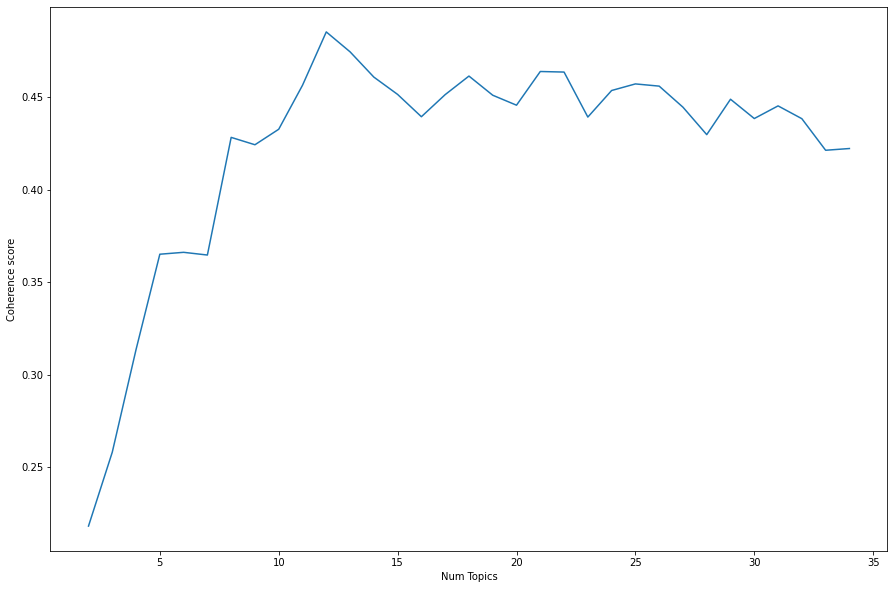

In [90]:
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [91]:

index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 10
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.026*"team" + 0.025*"wood" + 0.021*"broom" + 0.018*"match" + '
  '0.016*"snitch" + 0.015*"slytherin" + 0.013*"ball" + 0.013*"field" + '
  '0.012*"crowd" + 0.012*"madam"'),
 (1,
  '0.014*"bill" + 0.011*"goblin" + 0.011*"brother" + 0.010*"albus" + '
  '0.009*"young" + 0.008*"sister" + 0.008*"shop" + 0.008*"object" + '
  '0.008*"wizarding" + 0.008*"mirror"'),
 (2,
  '0.038*"yeh" + 0.032*"ter" + 0.026*"tree" + 0.022*"forest" + 0.018*"giant" + '
  '0.014*"creature" + 0.013*"fang" + 0.013*"dragon" + 0.012*"em" + '
  '0.011*"enormous"'),
 (3,
  '0.056*"neville" + 0.039*"mcgonagall" + 0.020*"filch" + 0.017*"luna" + '
  '0.017*"goyle" + 0.017*"crabbe" + 0.016*"hat" + 0.014*"percy" + '
  '0.012*"peeve" + 0.011*"staircase"'),
 (4,
  '0.012*"water" + 0.008*"middle" + 0.007*"inch" + 0.007*"stepped" + '
  '0.007*"covered" + 0.007*"jumped" + 0.007*"golden" + 0.007*"invisibility" + '
  '0.006*"slid" + 0.006*"sky"'),
 (5,
  '0.030*"fudge" + 0.019*"kreacher" + 0.018*"minister" + 0.015*"tonks" +

In [92]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['team', 'wood', 'broom', 'match', 'snitch', 'slytherin', 'ball', 'field', 'crowd', 'madam']
Topic 1: ['bill', 'goblin', 'brother', 'albus', 'young', 'sister', 'shop', 'object', 'wizarding', 'mirror']
Topic 2: ['yeh', 'ter', 'tree', 'forest', 'giant', 'creature', 'fang', 'dragon', 'em', 'enormous']
Topic 3: ['neville', 'mcgonagall', 'filch', 'luna', 'goyle', 'crabbe', 'hat', 'percy', 'peeve', 'staircase']
Topic 4: ['water', 'middle', 'inch', 'stepped', 'covered', 'jumped', 'golden', 'invisibility', 'slid', 'sky']
Topic 5: ['fudge', 'kreacher', 'minister', 'tonks', 'mundungus', 'portrait', 'arthur', 'month', 'desk', 'prophet']
Topic 6: ['lupin', 'james', 'dementors', 'map', 'crookshanks', 'madam', 'scabbers', 'lily', 'buckbeak', 'hogsmeade']
Topic 7: ['moody', 'crouch', 'cedric', 'krum', 'bagman', 'fleur', 'rita', 'percy', 'champion', 'diggory']
Topic 8: ['eater', 'lord', 'pain', 'snake', 'scar', 'bellatrix', 'master', 'wormtail', 'sword', 'flew']
Topic 9: ['uncle', 'vernon', '

In [133]:
def format_topics_sentences(ldamodel=model, corpus=corpus, texts=texts,index=all_books.index):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords,texts[i]]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','Text']
    sent_topics_df.index = index
    
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=all_books['Text'].to_list(),index=all_books.index)

# Show
df_topic_sents_keywords

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Dominant_Topic  ...                                               Text
Book Chapter                  ...                                                   
1    1                   9.0  ...  THE BOY WHO LIVED  Mr. and Mrs. Dursley, of nu...
     2                   9.0  ...  THE VANISHING GLASS  Nearly ten years had pass...
     3                   9.0  ...  THE LETTERS FROM NO ONE  The escape of the Bra...
     4                   2.0  ...  THE KEEPER OF THE KEYS  BOOM. They knocked aga...
     5                   1.0  ...  DIAGON ALLEY  Harry woke early the next mornin...
...                      ...  ...                                                ...
7    33                  8.0  ...  Harry remained kneeling at Snape's side, simpl...
     34                  8.0  ...  Finally, the truth. Lying with his face presse...
     35                  1.0  ...  He lay facedown, listening to the silence. He ...
     36                  8.0  ...  He was flying facedown on the ground again. Th...
     37                  1.0  ...  Autumn seemed to arrive suddenly that year. Th...

[200 rows x 4 columns]

In [137]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

Topic_Num  ...                                               Text
Book Chapter             ...                                                   
1    11             0.0  ...  QUIDDITCH  As they entered November, the weath...
7    18             1.0  ...  The sun was coming up: The pure, colorless vas...
5    20             2.0  ...  Hagrid's TaleHarry sprinted up to the boys' do...
1    7              3.0  ...  THE SORTING HAT  The door swung open at once. ...
5    34             4.0  ...  The DepartmentOf MysteriesHarry wound his hand...
6    1              5.0  ...   It was nearing midnight and the Prime Ministe...
3    19             6.0  ...    THE SERVANT OF LORD VOLDEMORT  Hermione scre...
4    17             7.0  ...     Harry sat there, aware that every head in t...
     33             8.0  ...     Voldemort looked away from Harry and began ...
3    2              9.0  ...    AUNT MARGE'S BIG MISTAKE  Harry went down to...
5    15            10.0  ...  The Hogwart's HighInquisitorThey had expected ...
2    19            11.0  ...    \What d'you mean, I won't be -?\"  \"I've wa...

[12 rows x 4 columns]

In [138]:
unseen_document = 'Umbridge exam fred george firework'
bow_vector = dictionary.doc2bow(unseen_document.split())
for index, score in sorted(optimal_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, optimal_model.print_topic(index, 5)))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Score: 0.09477124183006533	 Topic: 0.038*"yeh" + 0.032*"ter" + 0.026*"tree" + 0.022*"forest" + 0.018*"giant"
Score: 0.08823529411764702	 Topic: 0.035*"umbridge" + 0.022*"class" + 0.017*"lesson" + 0.014*"trelawney" + 0.013*"owl"
Score: 0.08169934640522873	 Topic: 0.026*"team" + 0.025*"wood" + 0.021*"broom" + 0.018*"match" + 0.016*"snitch"
Score: 0.08169934640522873	 Topic: 0.014*"bill" + 0.011*"goblin" + 0.011*"brother" + 0.010*"albus" + 0.009*"young"
Score: 0.08169934640522873	 Topic: 0.056*"neville" + 0.039*"mcgonagall" + 0.020*"filch" + 0.017*"luna" + 0.017*"goyle"
Score: 0.08169934640522873	 Topic: 0.012*"water" + 0.008*"middle" + 0.007*"inch" + 0.007*"stepped" + 0.007*"covered"
Score: 0.08169934640522873	 Topic: 0.030*"fudge" + 0.019*"kreacher" + 0.018*"minister" + 0.015*"tonks" + 0.008*"mundungus"
Score: 0.08169934640522873	 Topic: 0.081*"lupin" + 0.019*"james" + 0.018*"dementors" + 0.016*"map" + 0.016*"crookshanks"
Score: 0.08169934640522873	 Topic: 0.052*"moody" + 0.034*"crouch"

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
